In [1]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse, mse, meanabs
from sklearn.metrics import mean_absolute_percentage_error as calc_mape
from arch.unitroot import ADF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore", category=UserWarning)
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['figure.dpi'] = 400

My last two numbers are 60

In [2]:
print(60 % 7)

4


This means Peninsula is my region

In [3]:
df = pd.read_csv('data/clean/hourly.csv')
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')
df.set_index('time', inplace=True)
df.head()

,kWh
time,
2021-01-01 00:00:00,6.033
2021-01-01 01:00:00,0.890
2021-01-01 02:00:00,10.180
2021-01-01 03:00:00,12.630
2021-01-01 04:00:00,1.940


# 1. Валідація двох альтернатив: additive VS multiplicative

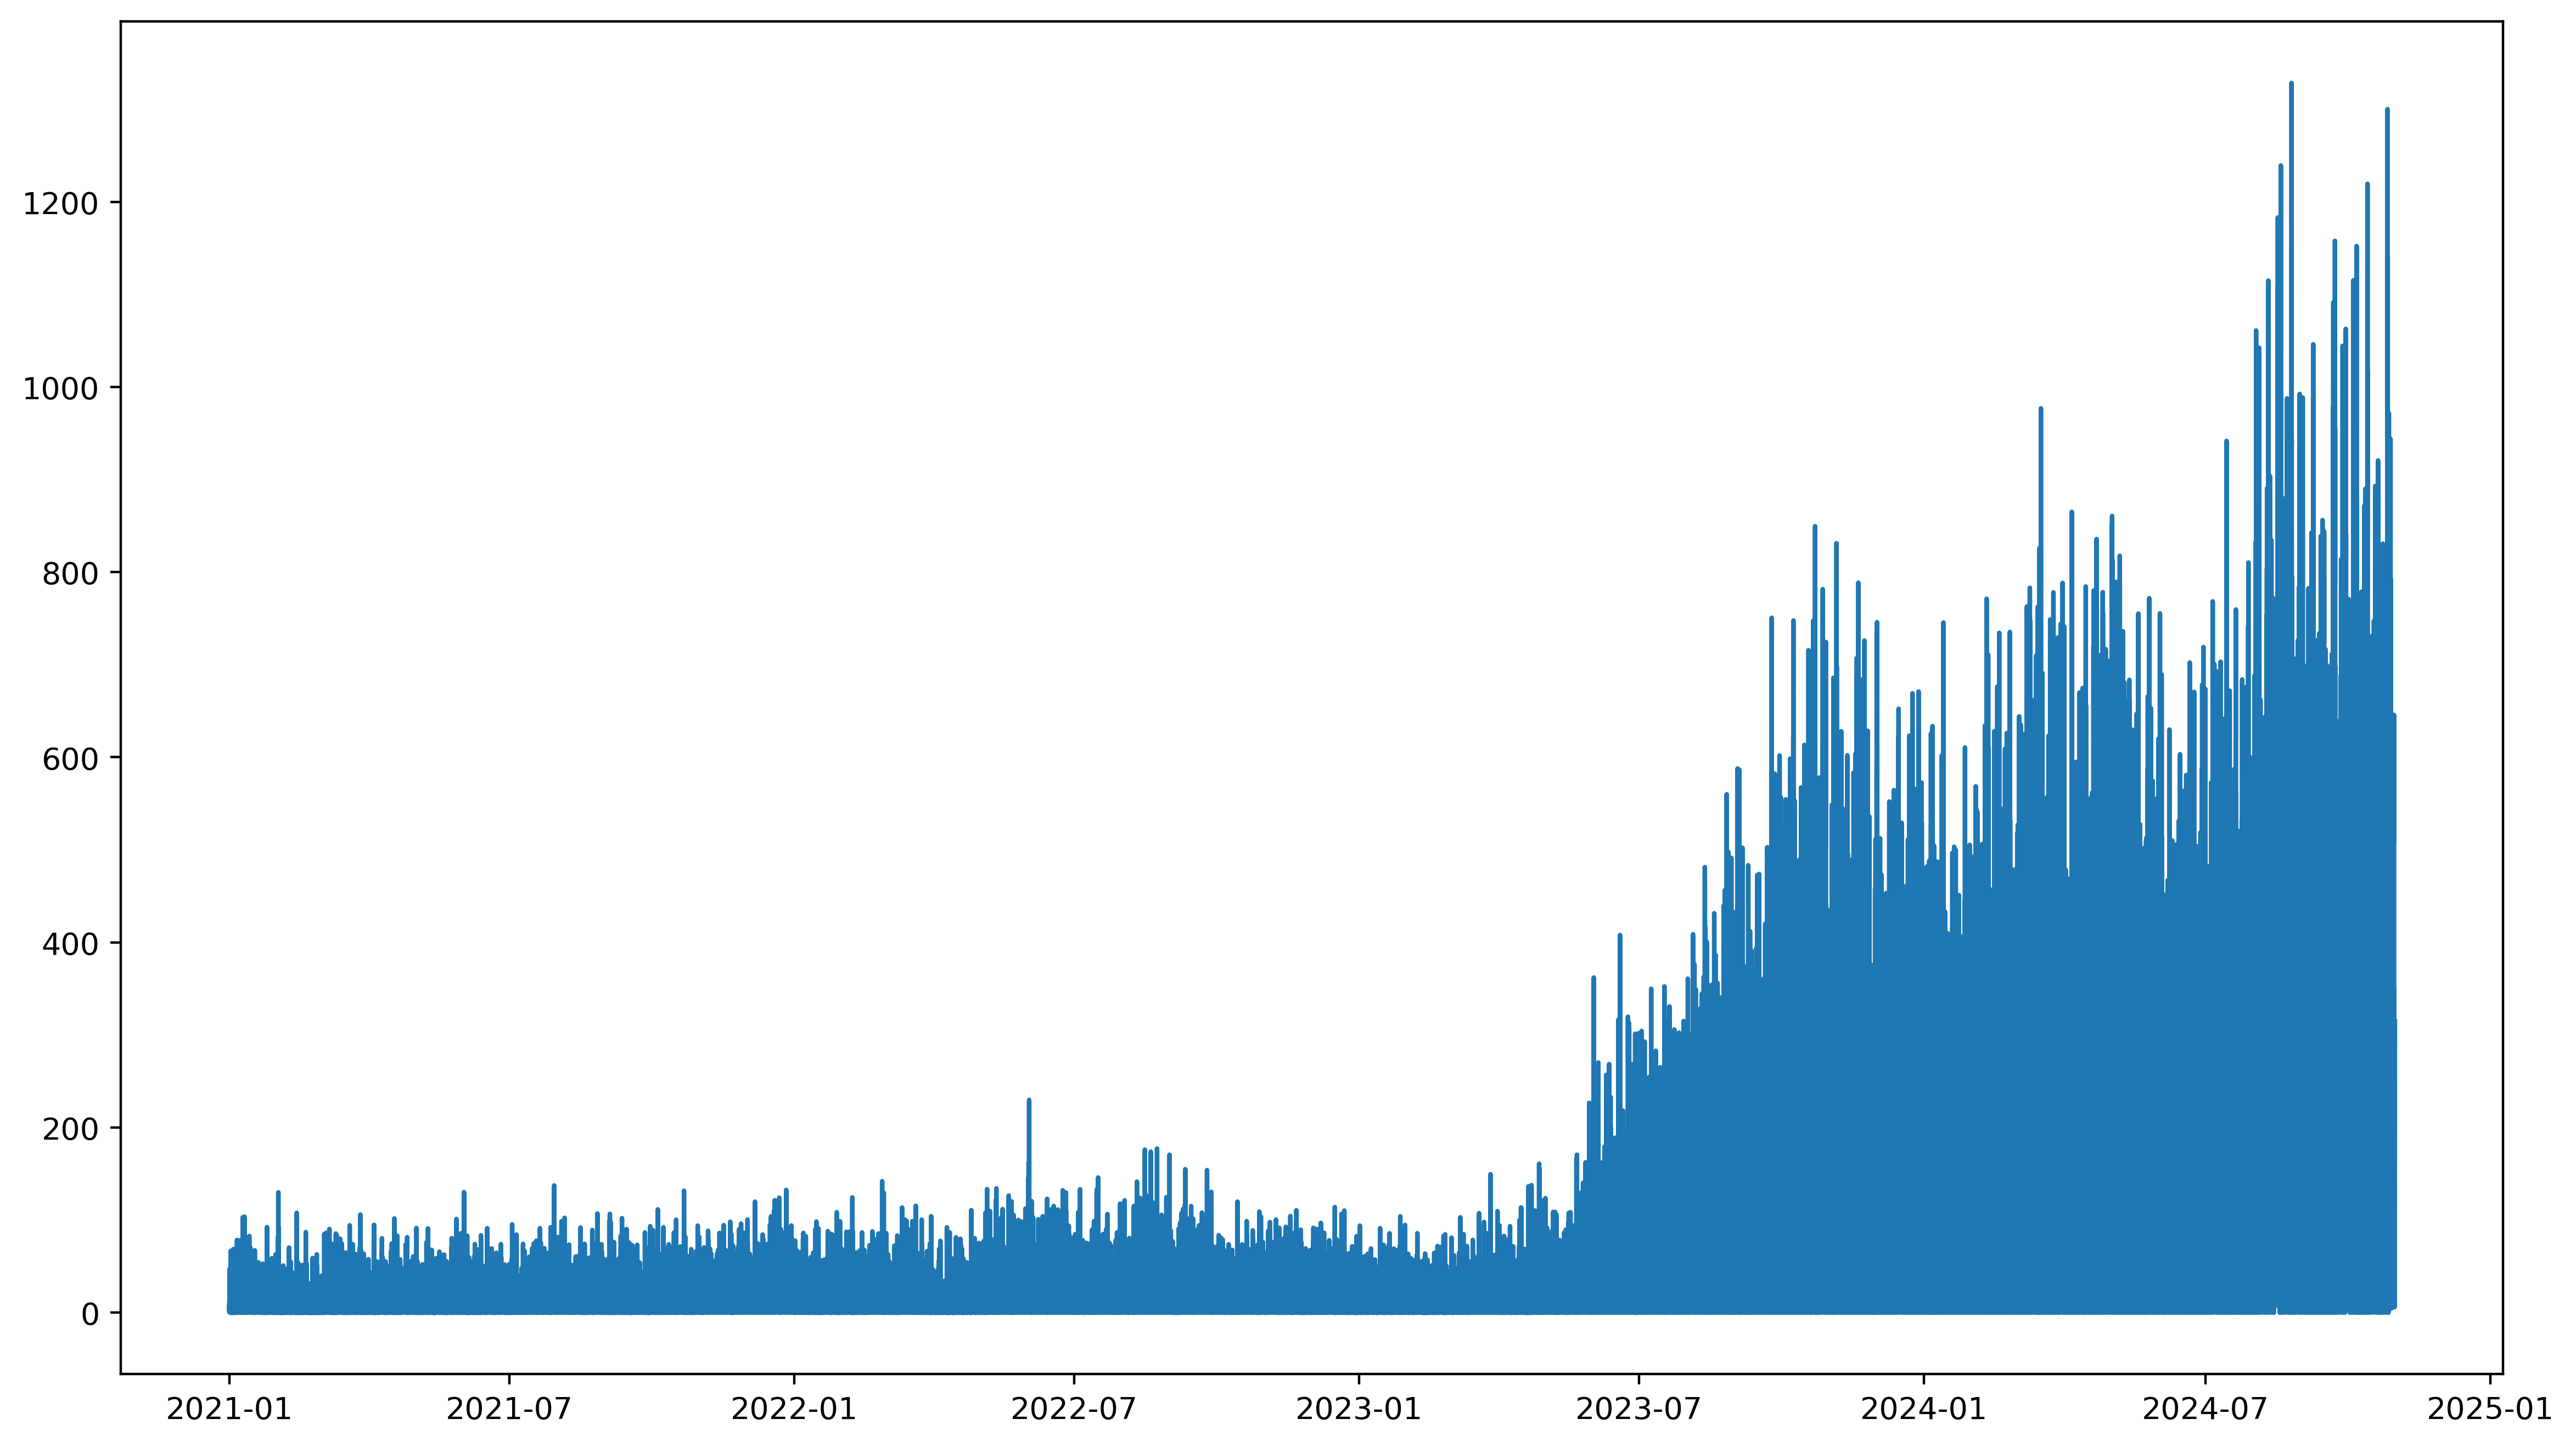

In [4]:
plt.plot(df.index, df['kWh'])
plt.show()

Judging by eye its hard to say which model would be preferred.

In [5]:
decomposition_additive = seasonal_decompose(df['kWh'], model='additive', period=24)
decomposition_multiplicative = seasonal_decompose(df['kWh'], model='additive', period=24)

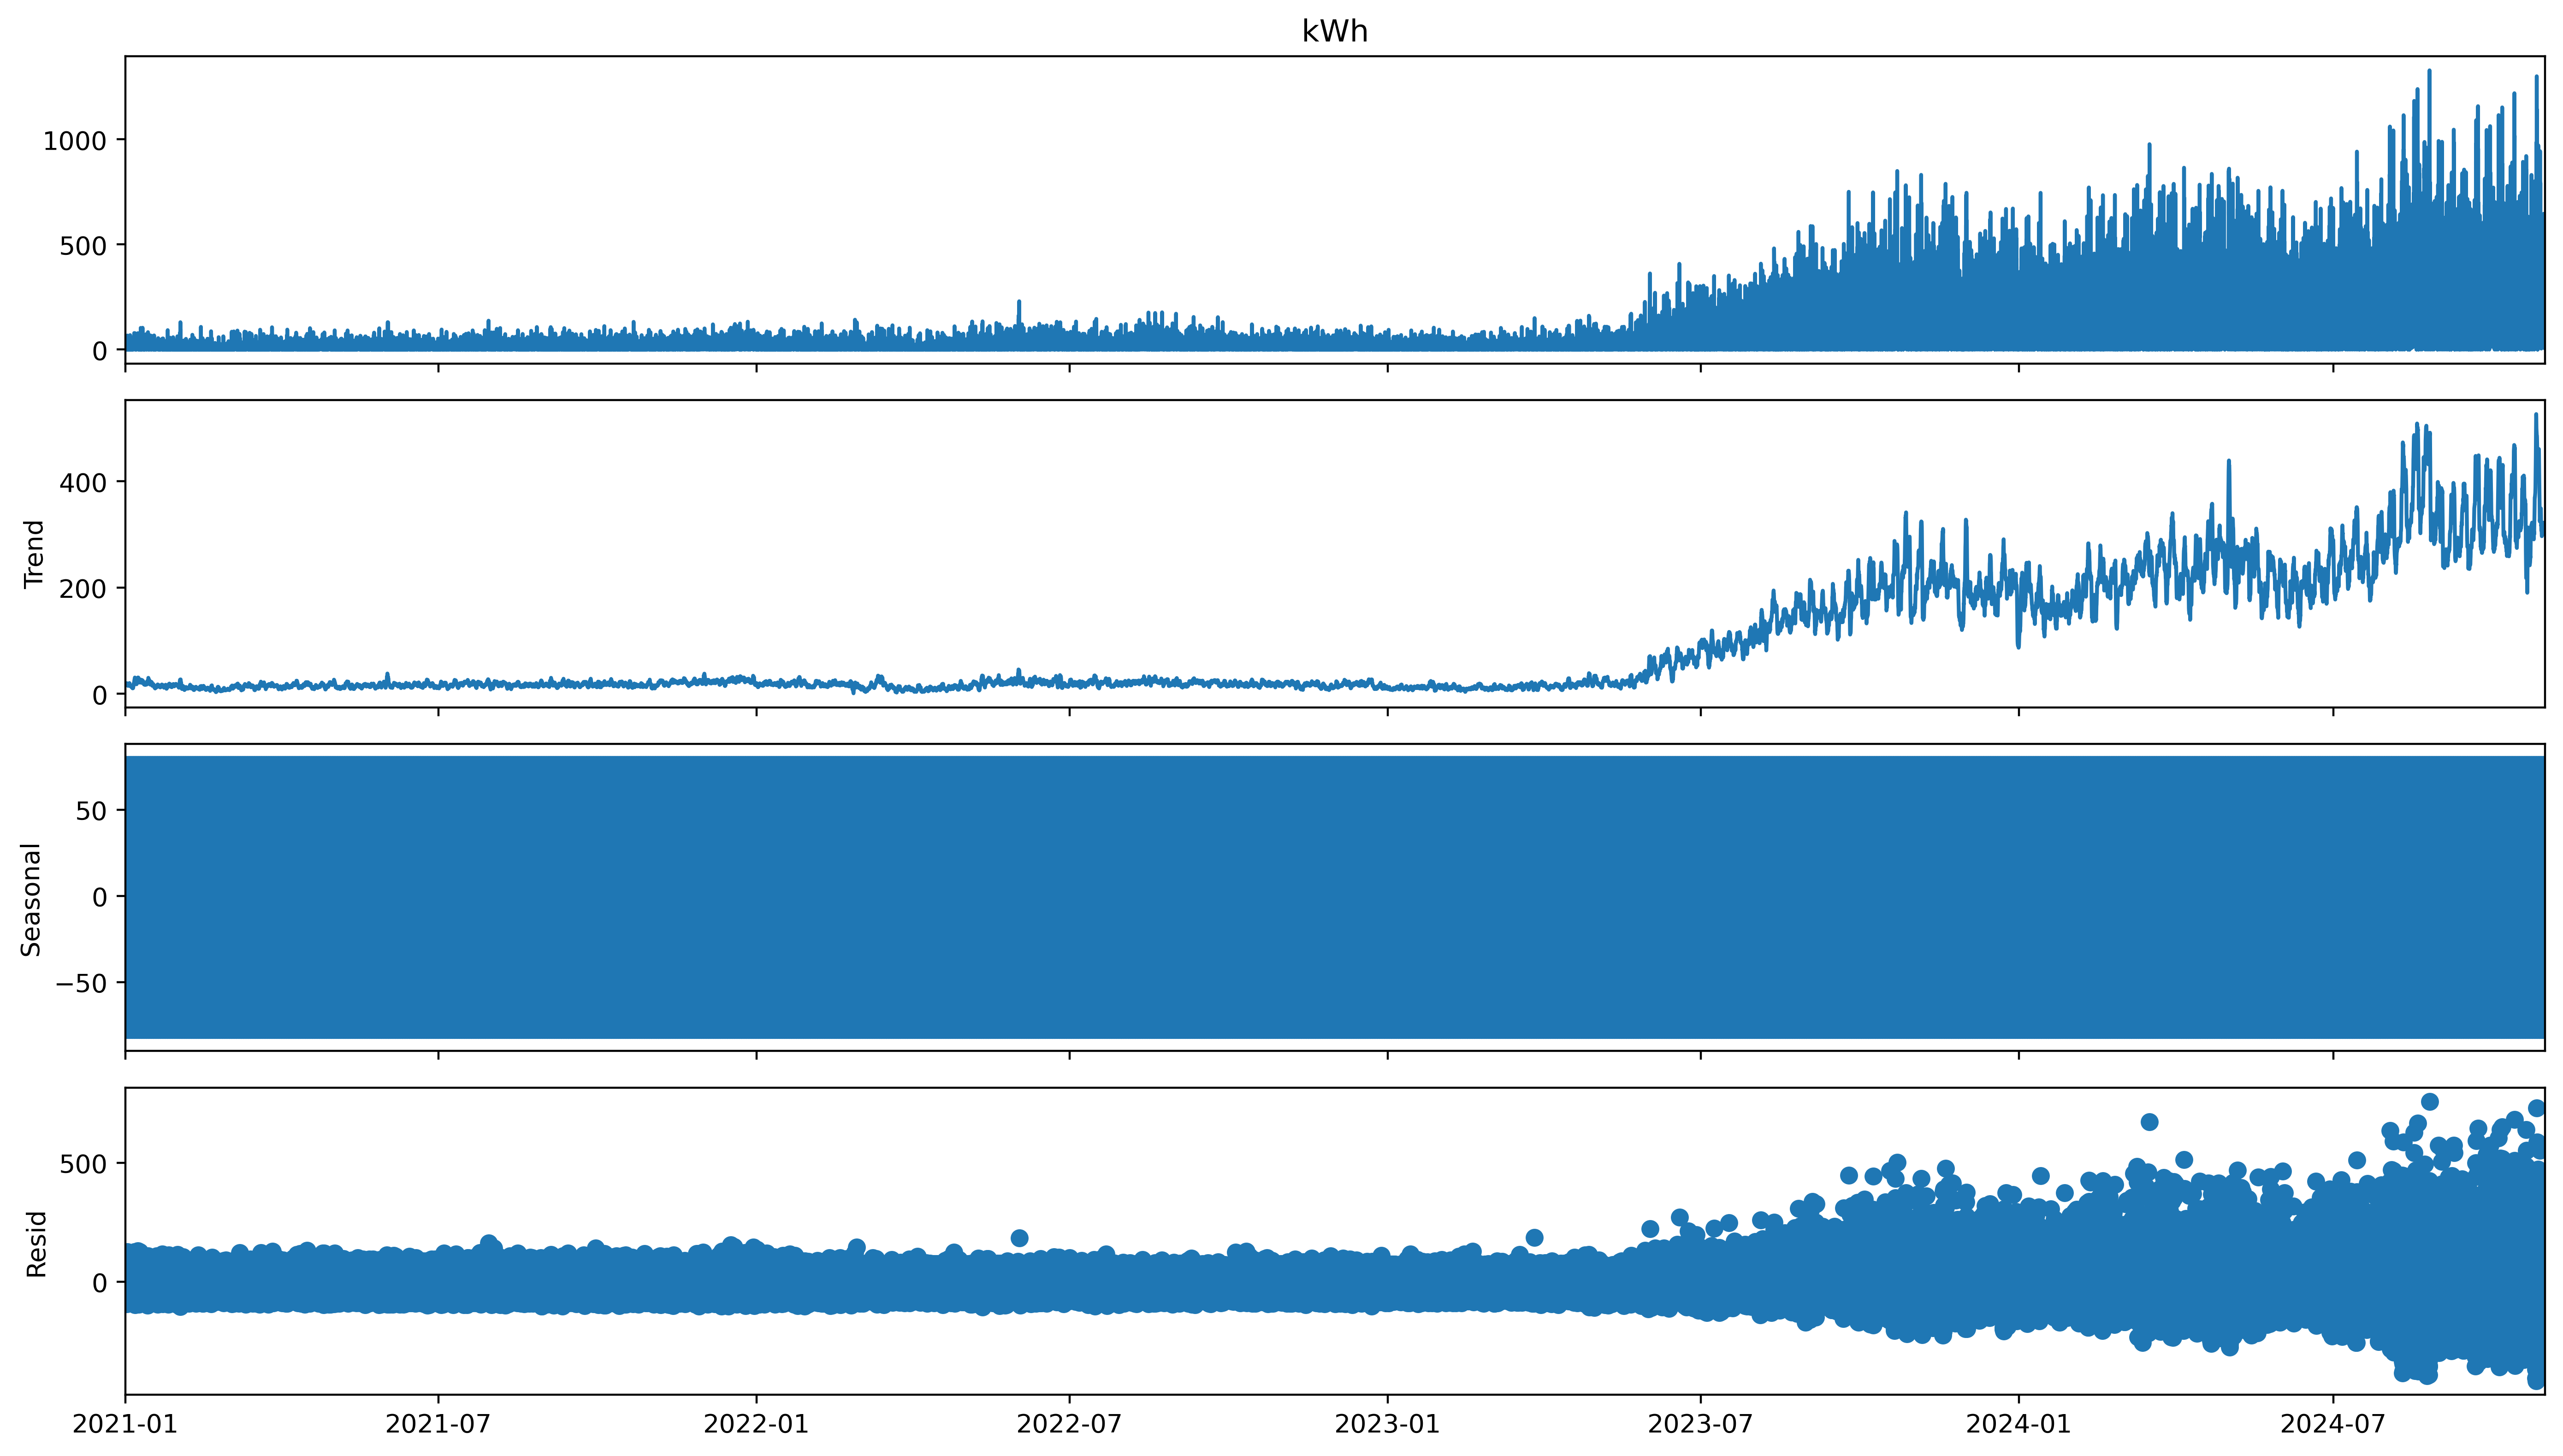

In [6]:
decomposition_additive.plot()
plt.show()

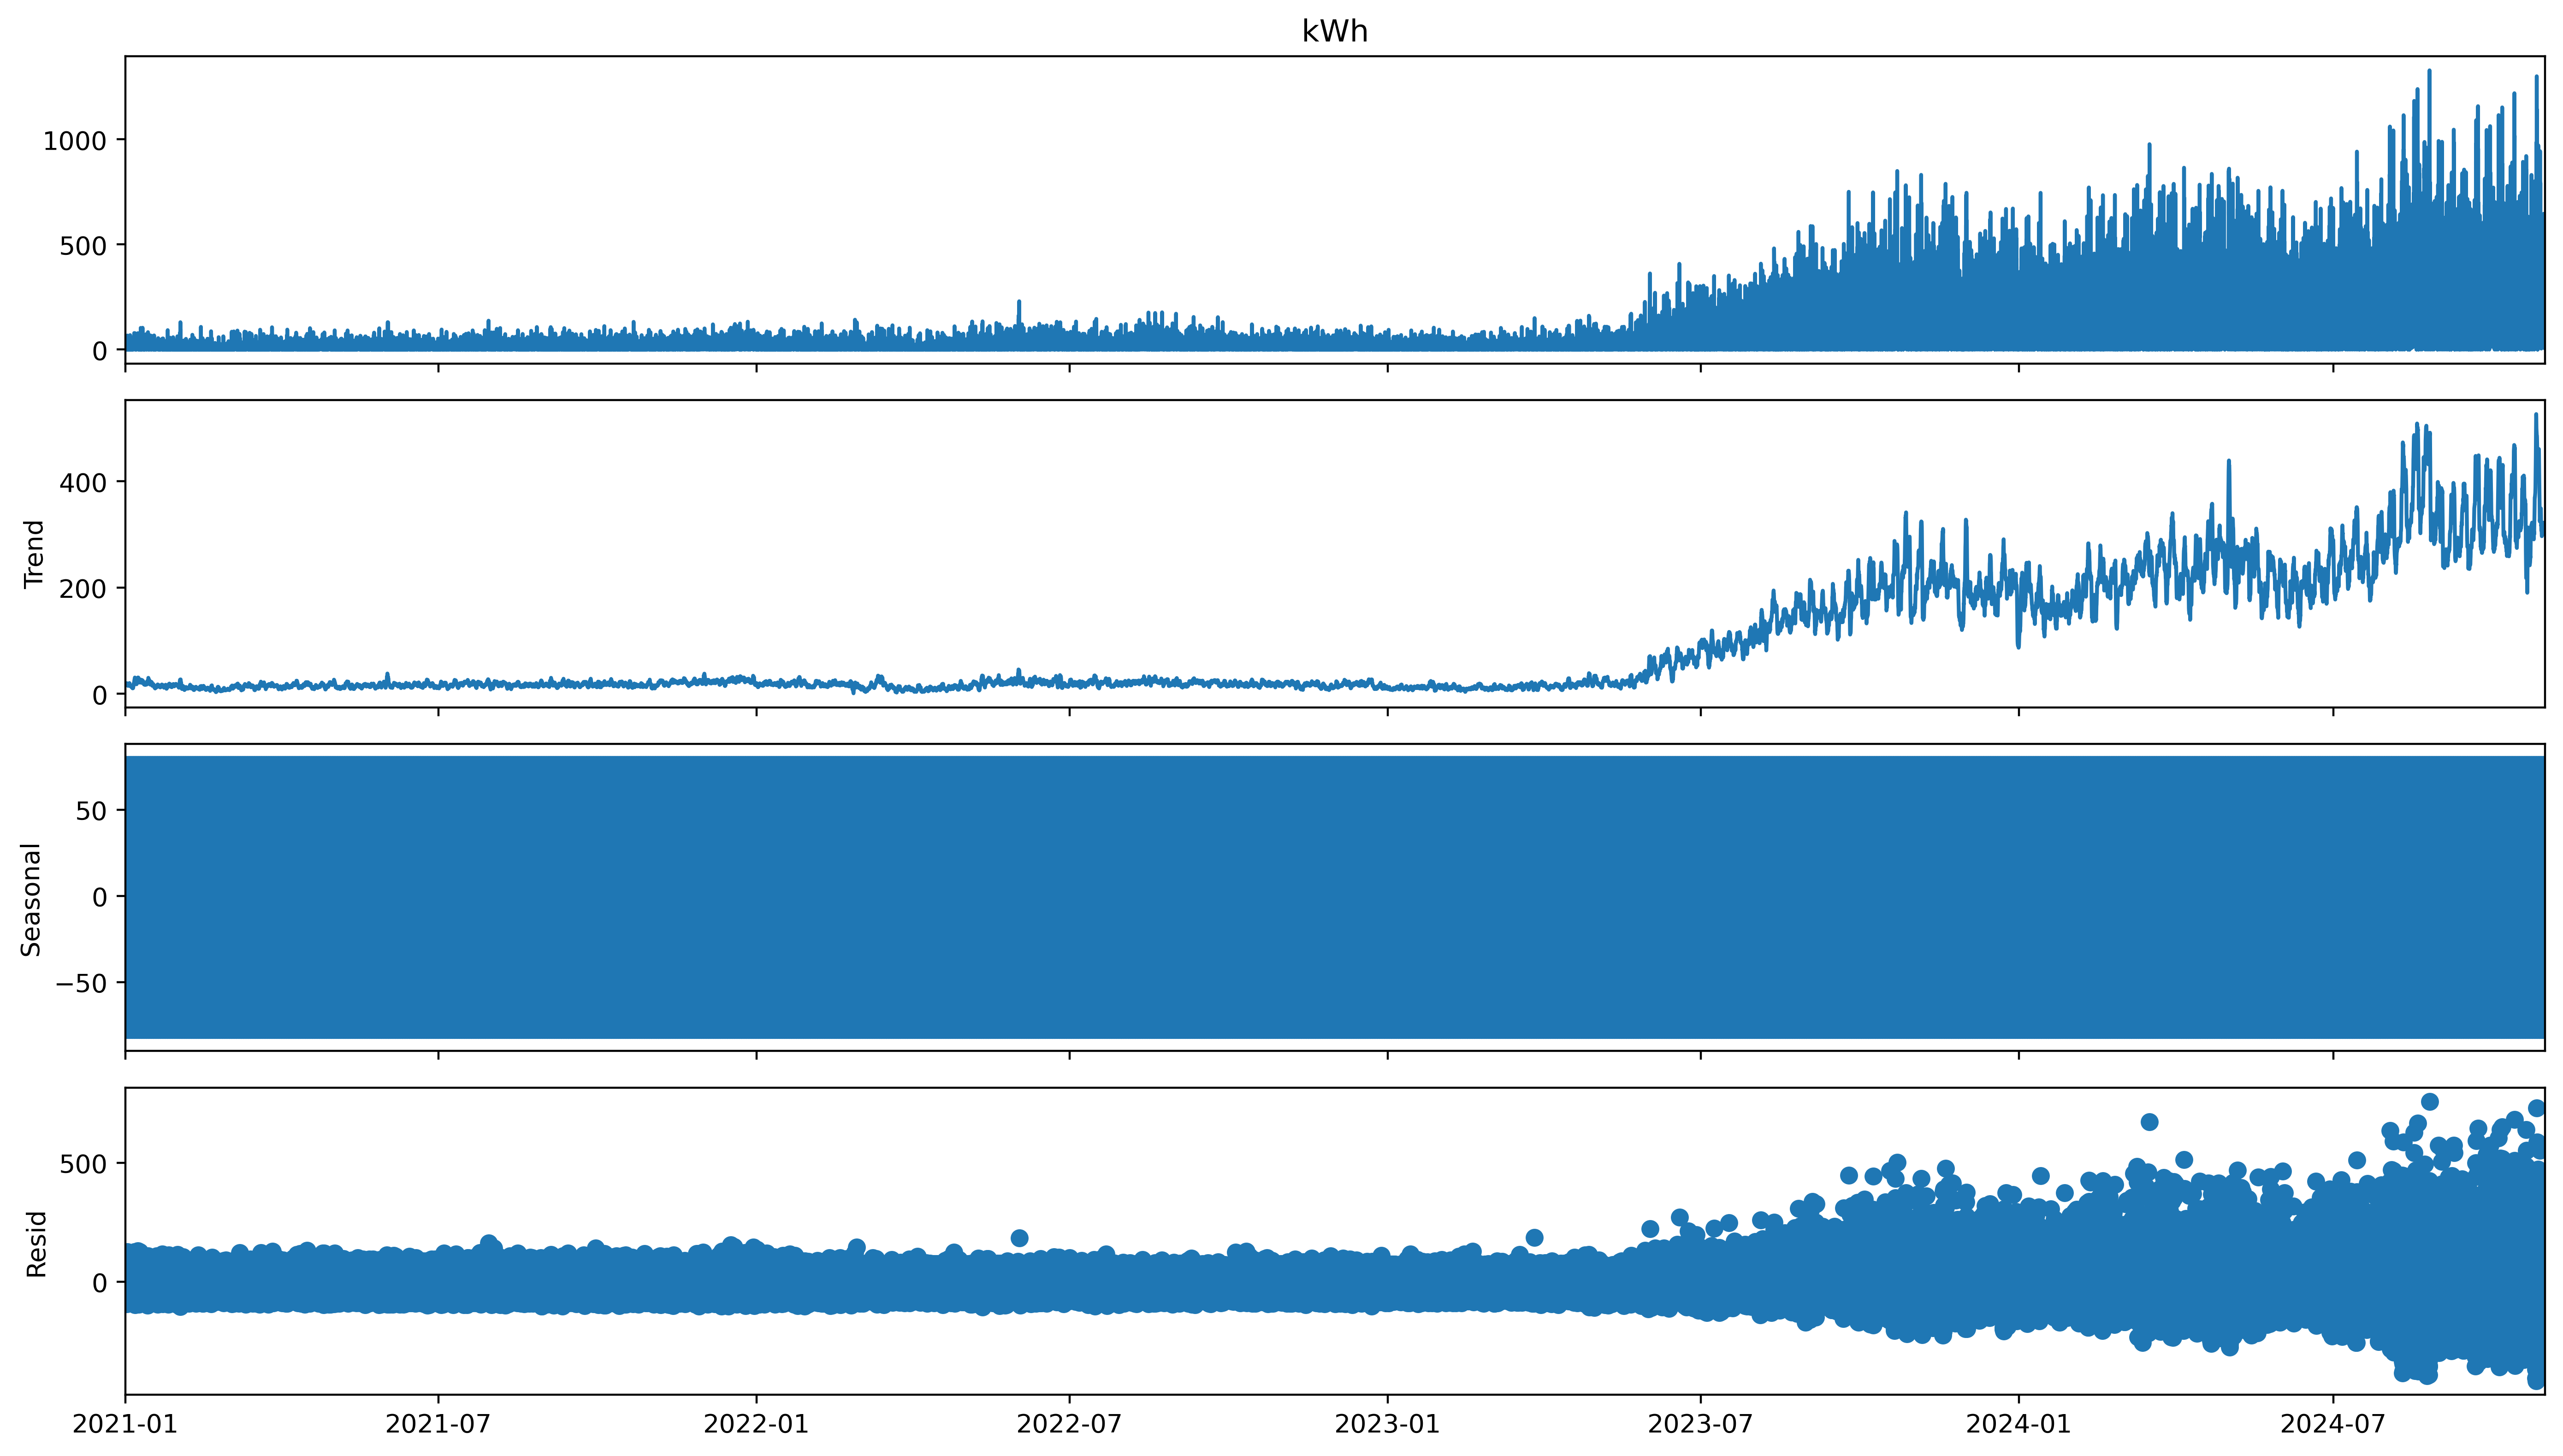

In [7]:
decomposition_multiplicative.plot()
plt.show()

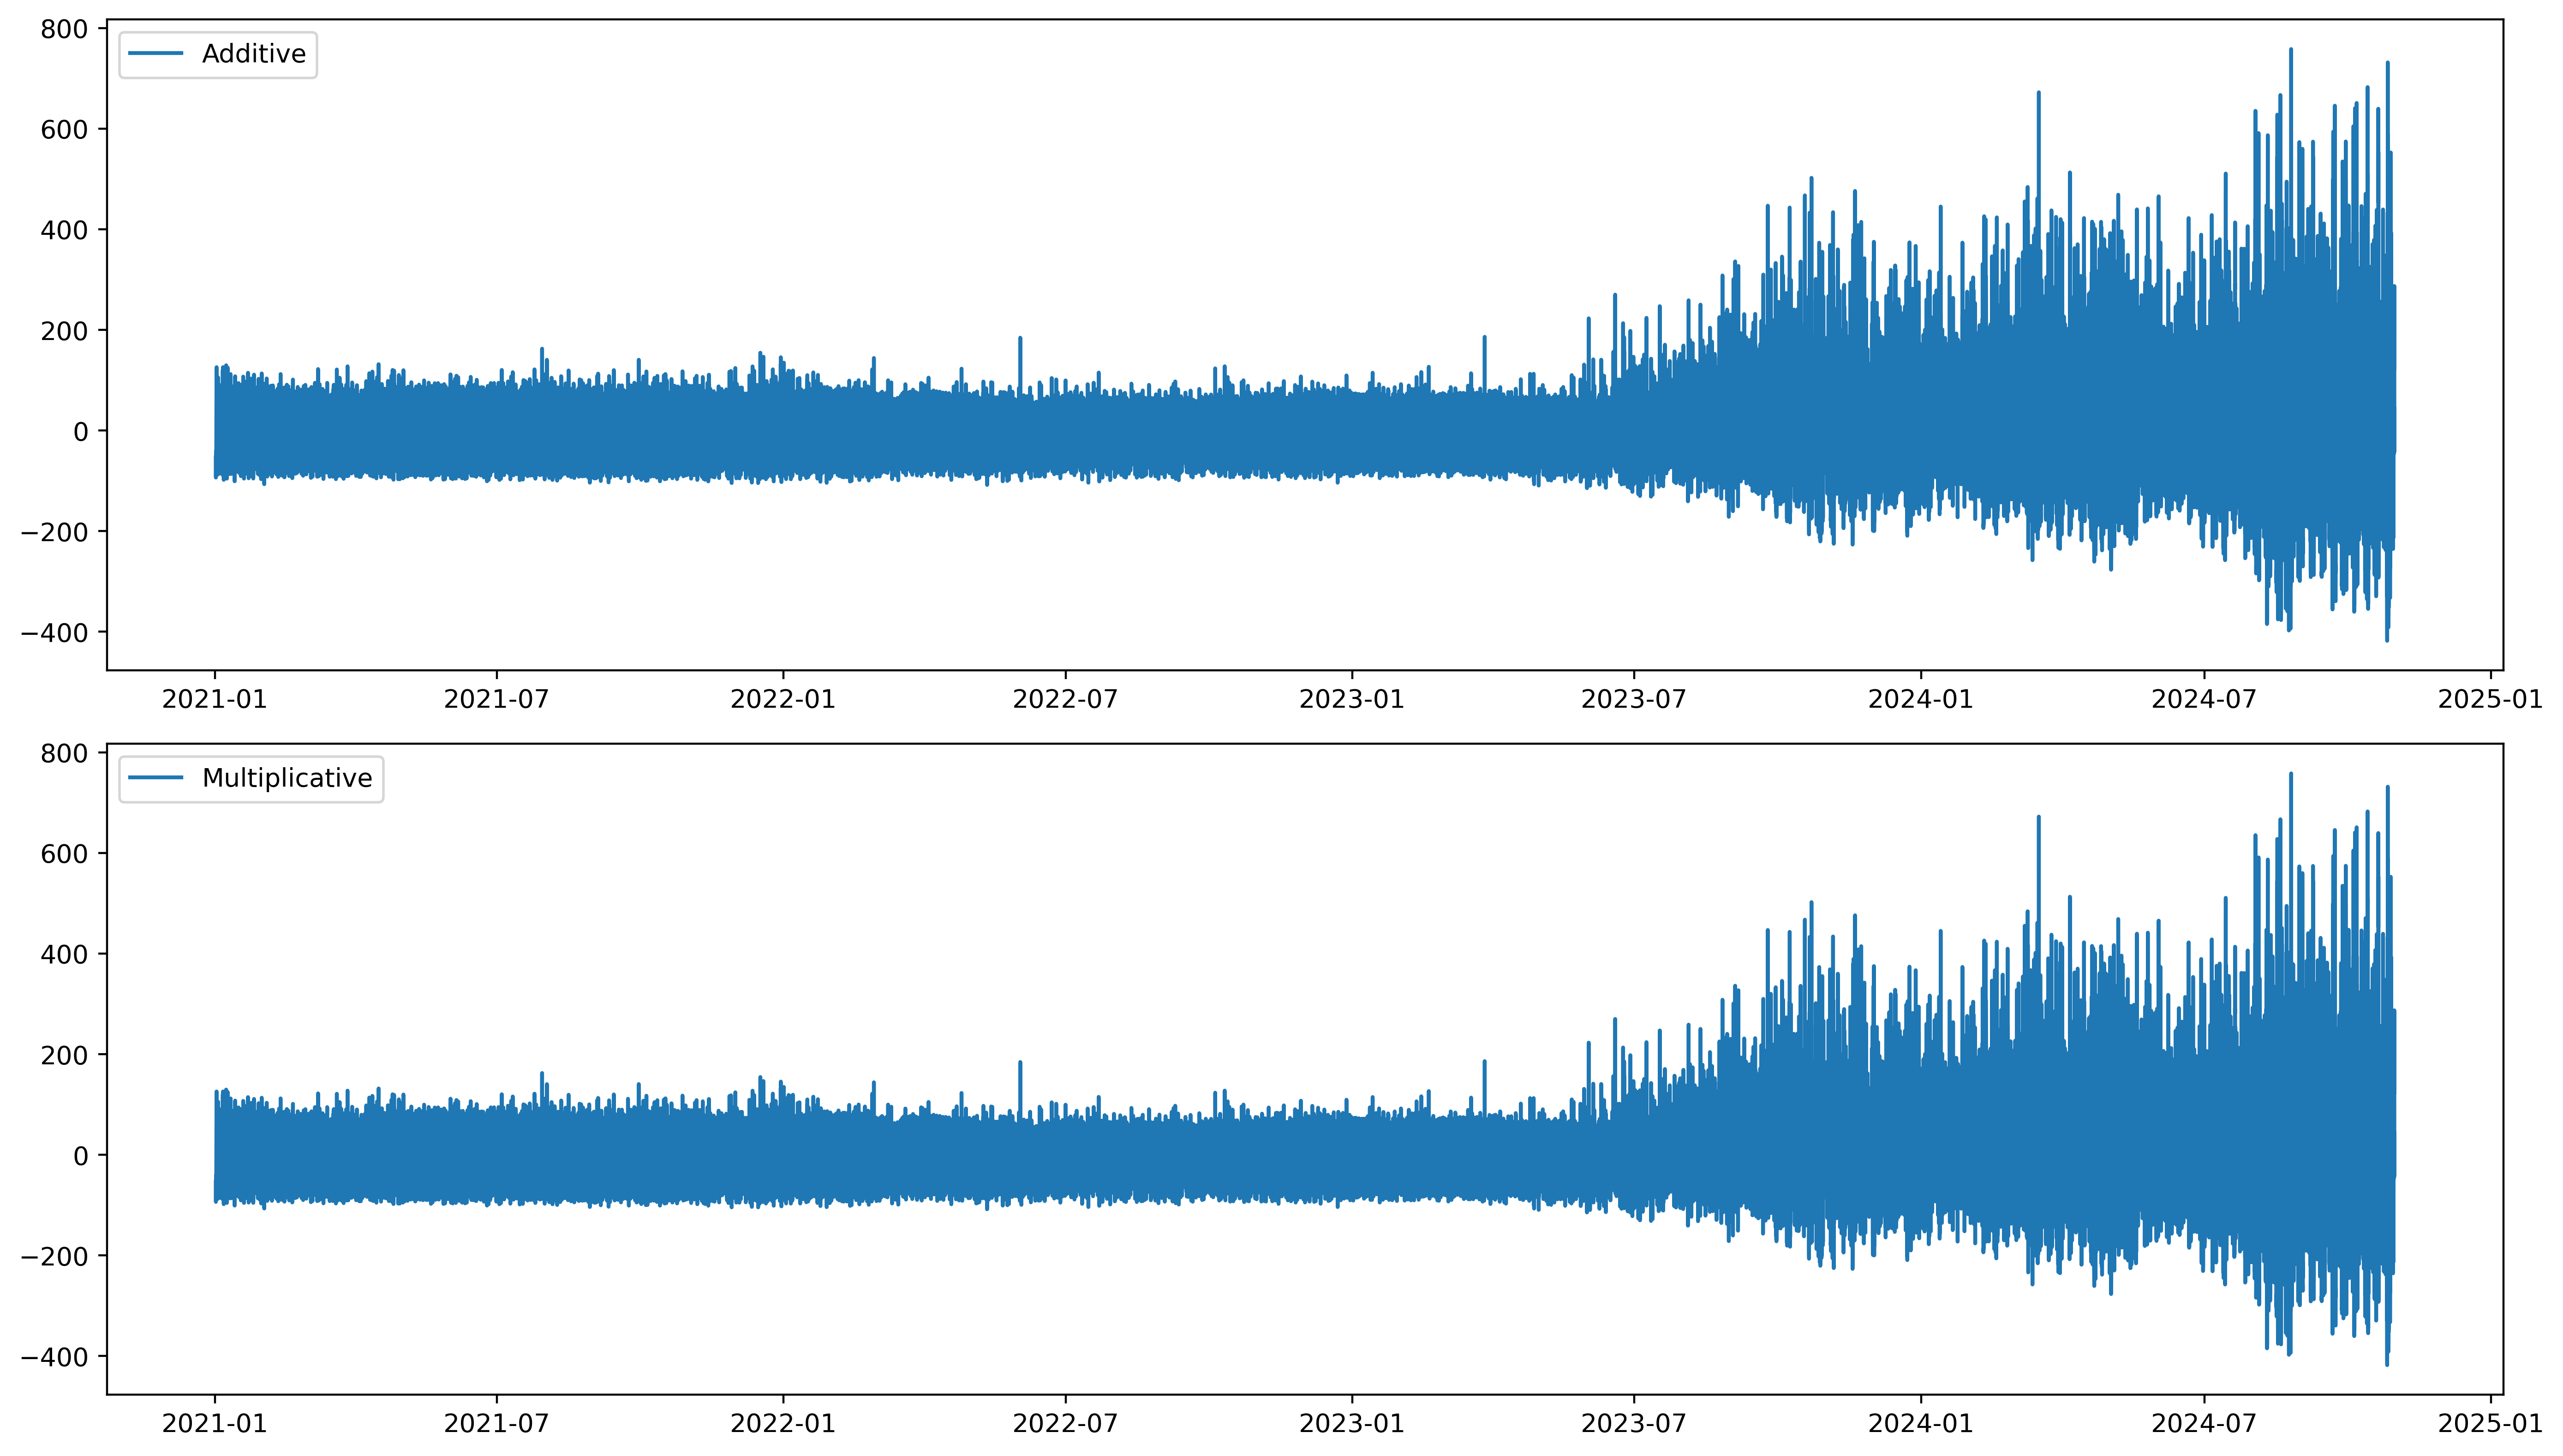

In [8]:
plt.figure()
plt.subplot(211)
plt.plot(decomposition_additive.resid, label='Additive')
plt.legend(loc='upper left')

plt.subplot(212)
plt.plot(decomposition_multiplicative.resid, label='Multiplicative')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

After plotting the results of both decomposition I am still not sure, the residuals of both seem stationary to me. Let's calculate RMSE.

In [9]:
def calculate_rmse(decompostition):
    return rmse(decompostition.resid.dropna(), [0]*len(decompostition.resid.dropna()))

In [10]:
additive_rmse = calculate_rmse(decomposition_additive)
multiplicative_rmse = calculate_rmse(decomposition_multiplicative)
print(f"Additive Model RMSE: {additive_rmse}")
print(f"Multiplicative Model RMSE: {multiplicative_rmse}")

Additive Model RMSE: 93.54197218984206
Multiplicative Model RMSE: 93.54197218984206


RMSE would suggest that Multiplicative model is much much much better. But let's also check MAPE.

In [11]:
def compare_residuals(decomposition_additive, decomposition_multiplicative):
    additive_resid = decomposition_additive.resid
    multiplicative_resid = decomposition_multiplicative.resid
    
    
    multiplicative_recon = decomposition_multiplicative.trend + decomposition_multiplicative.seasonal
    additive_recon = decomposition_additive.trend + decomposition_additive.seasonal
    
    mape_additive = calc_mape(additive_resid.dropna(), additive_recon.dropna())
    mape_multiplicative = calc_mape(multiplicative_resid.dropna(), multiplicative_recon.dropna())
    
    print(f"Additive Model MAPE = {mape_additive:.4f}")
    print(f"Multiplicative Model MAPE = {mape_multiplicative:.4f}")

In [12]:
compare_residuals(decomposition_additive, decomposition_multiplicative)

Additive Model MAPE = 6.3544
Multiplicative Model MAPE = 6.3544


As you can see here the picture is flipped with the multiplicative model coming off much worse. This is because RMSE deals only in absolutes (like a sith) while MAPE deals in relative terms. From now on I'll use MAPE.

In [13]:
print('Additive Model:')
print(ADF(decomposition_additive.resid.dropna(), lags=12).summary())

Additive Model:
   Augmented Dickey-Fuller Results   
Test Statistic               -109.762
P-value                         0.000
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [14]:
print('Multiplicative Model:')
print(ADF(decomposition_multiplicative.resid.dropna(), lags=12).summary())

Multiplicative Model:
   Augmented Dickey-Fuller Results   
Test Statistic               -109.762
P-value                         0.000
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


After running ADF my conclusions about MAPE and RMSE gain more support as the additve model has a lower test statisitic.

# 2. Описова частина (Seasonality, ACF, PACF, Moving Average, Exponential Smoothing, Differencing, Stationarity); 

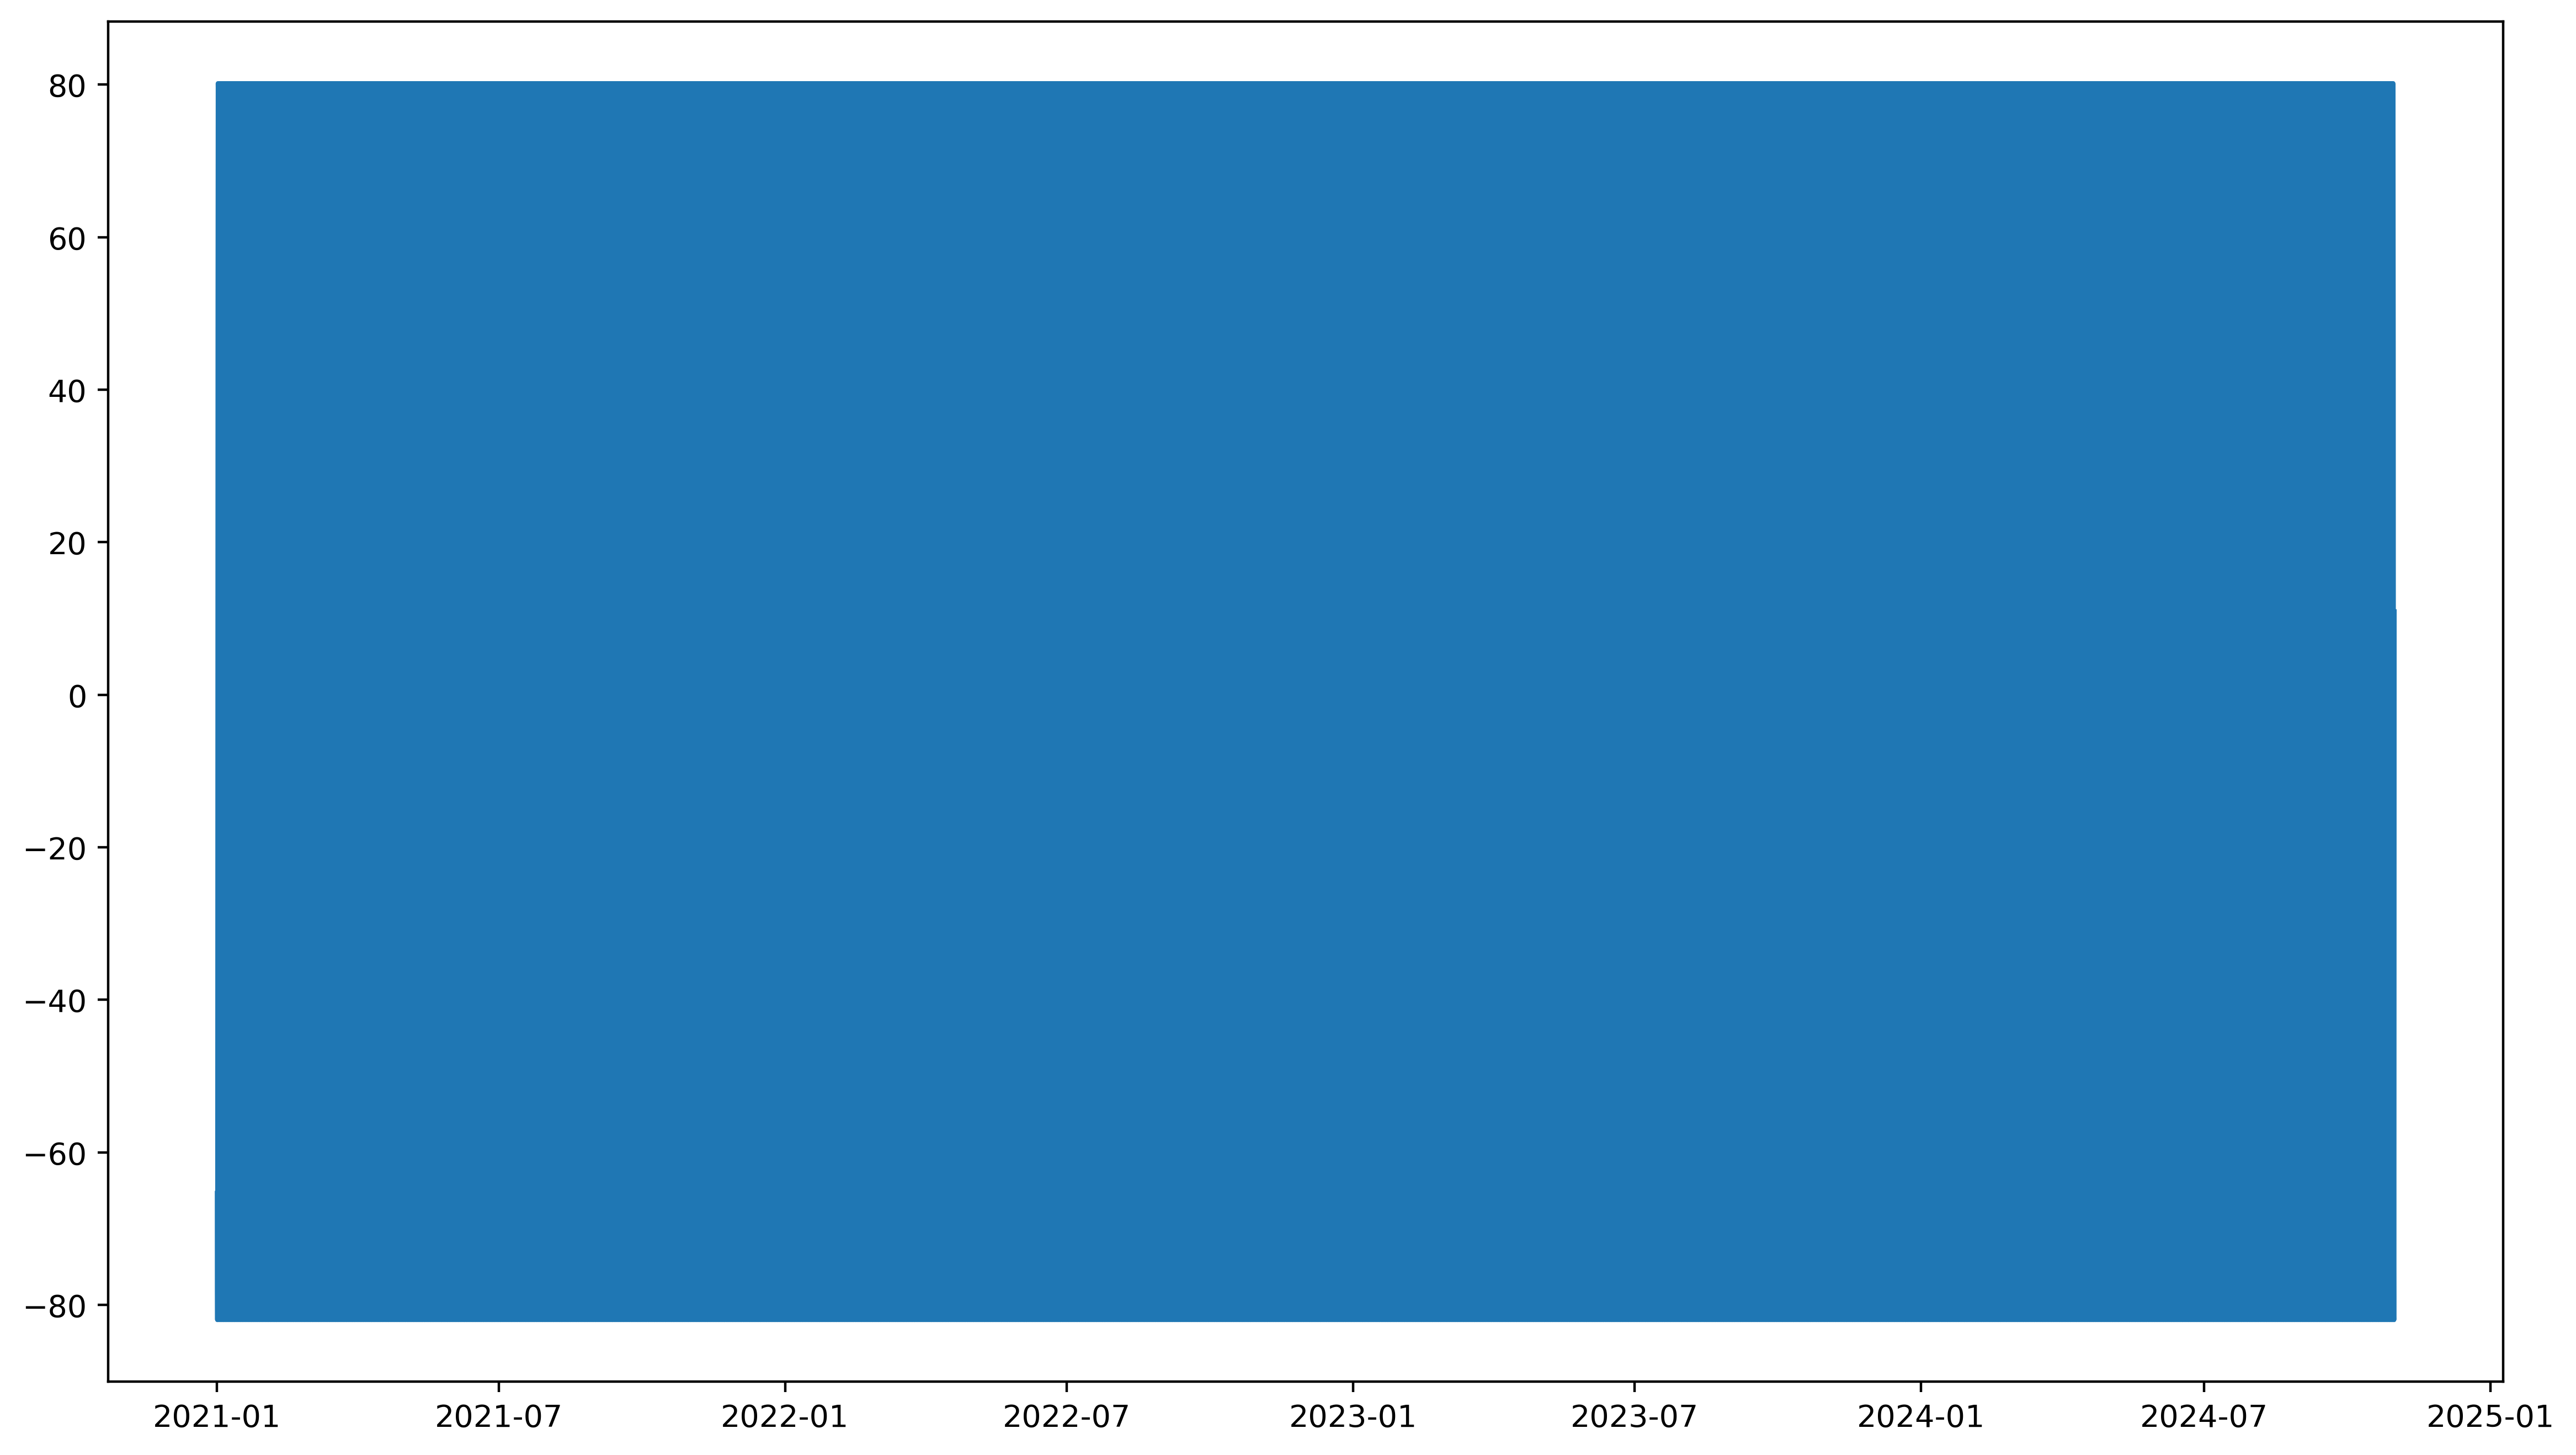

In [15]:
plt.plot(df.index, decomposition_additive.seasonal)
plt.show()

This is my seasonal component.

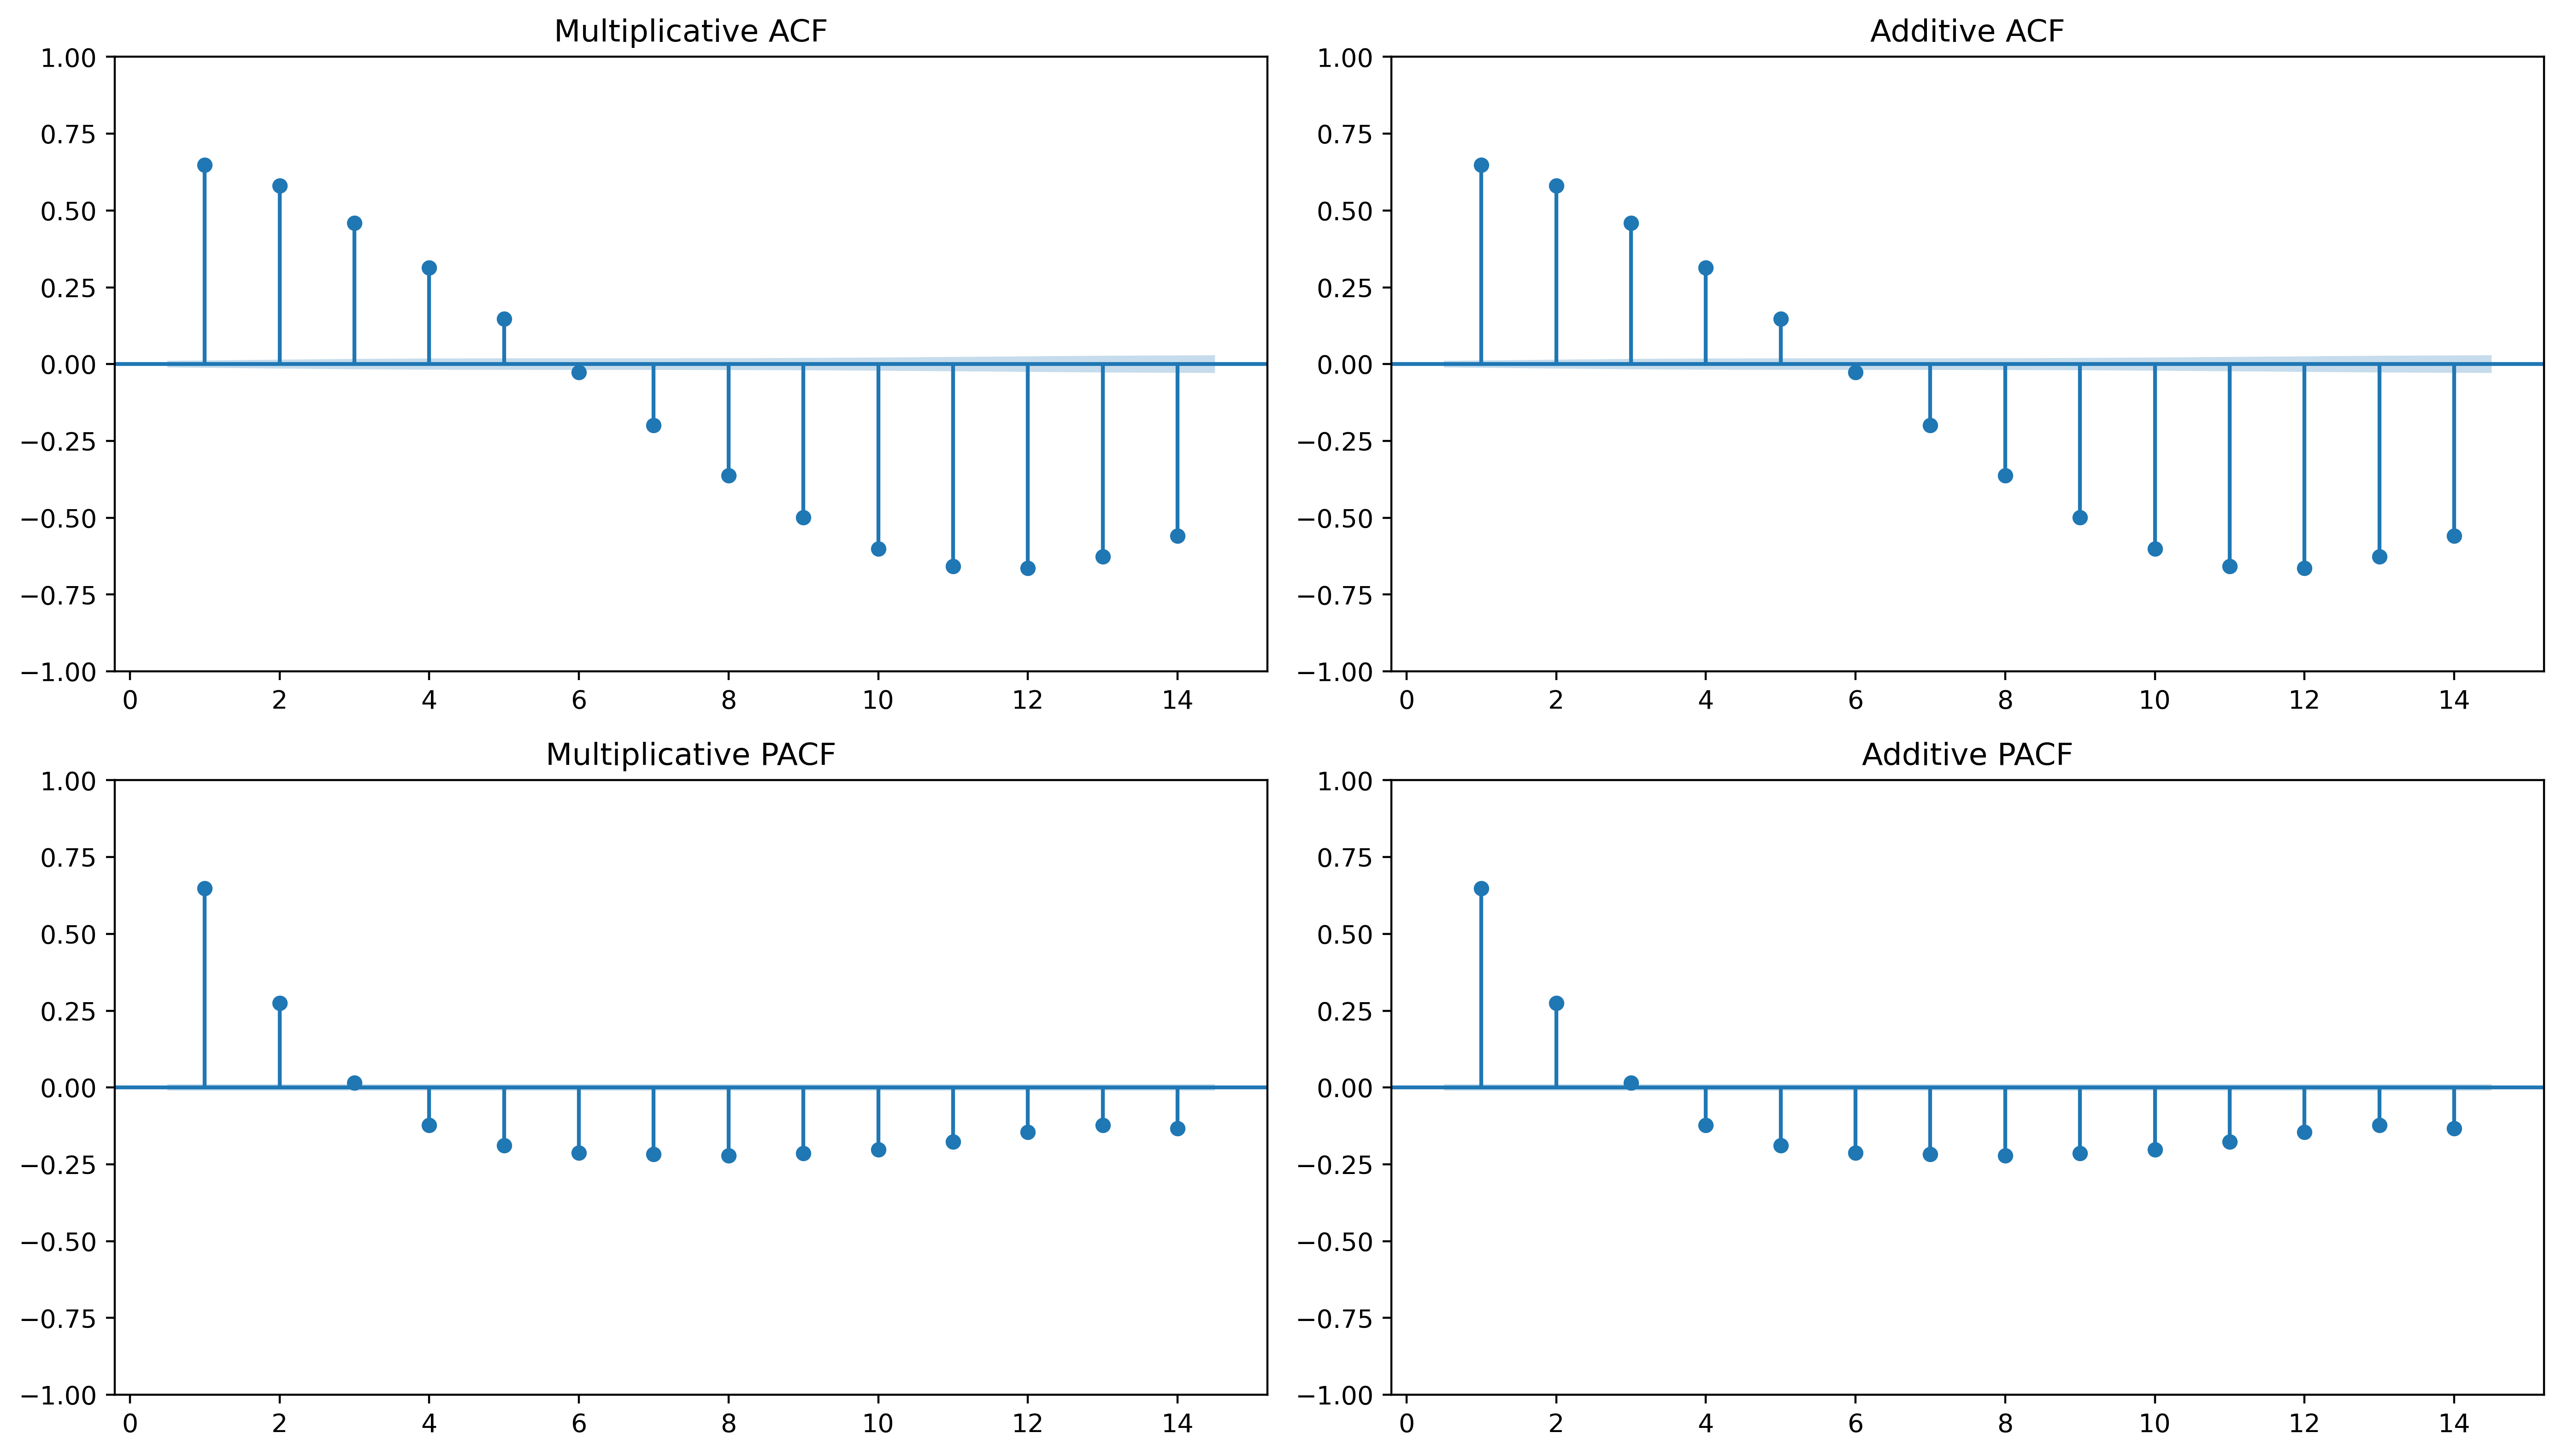

In [16]:
plt.subplot(221)
plot_acf(decomposition_multiplicative.resid.dropna(), lags=range(1, 15), ax=plt.gca())
plt.title('Multiplicative ACF')
plt.subplot(222)
plot_acf(decomposition_additive.resid.dropna(), lags=range(1, 15), ax=plt.gca())
plt.title('Additive ACF')
plt.subplot(223)
plot_pacf(decomposition_multiplicative.resid.dropna(), lags=range(1, 15), ax=plt.gca())
plt.title('Multiplicative PACF')
plt.subplot(224)
plot_pacf(decomposition_additive.resid.dropna(), lags=range(1, 15), ax=plt.gca())
plt.title('Additive PACF')
plt.tight_layout()
plt.show()

These are my ACF and PACF plots for the multiplicative and additive models respectively. Frankly I find them hard to interpret well and they are kind of useless to me. ACF seems to suggest I still have some unremoved seasonality while PACF is a complete mystery to me.

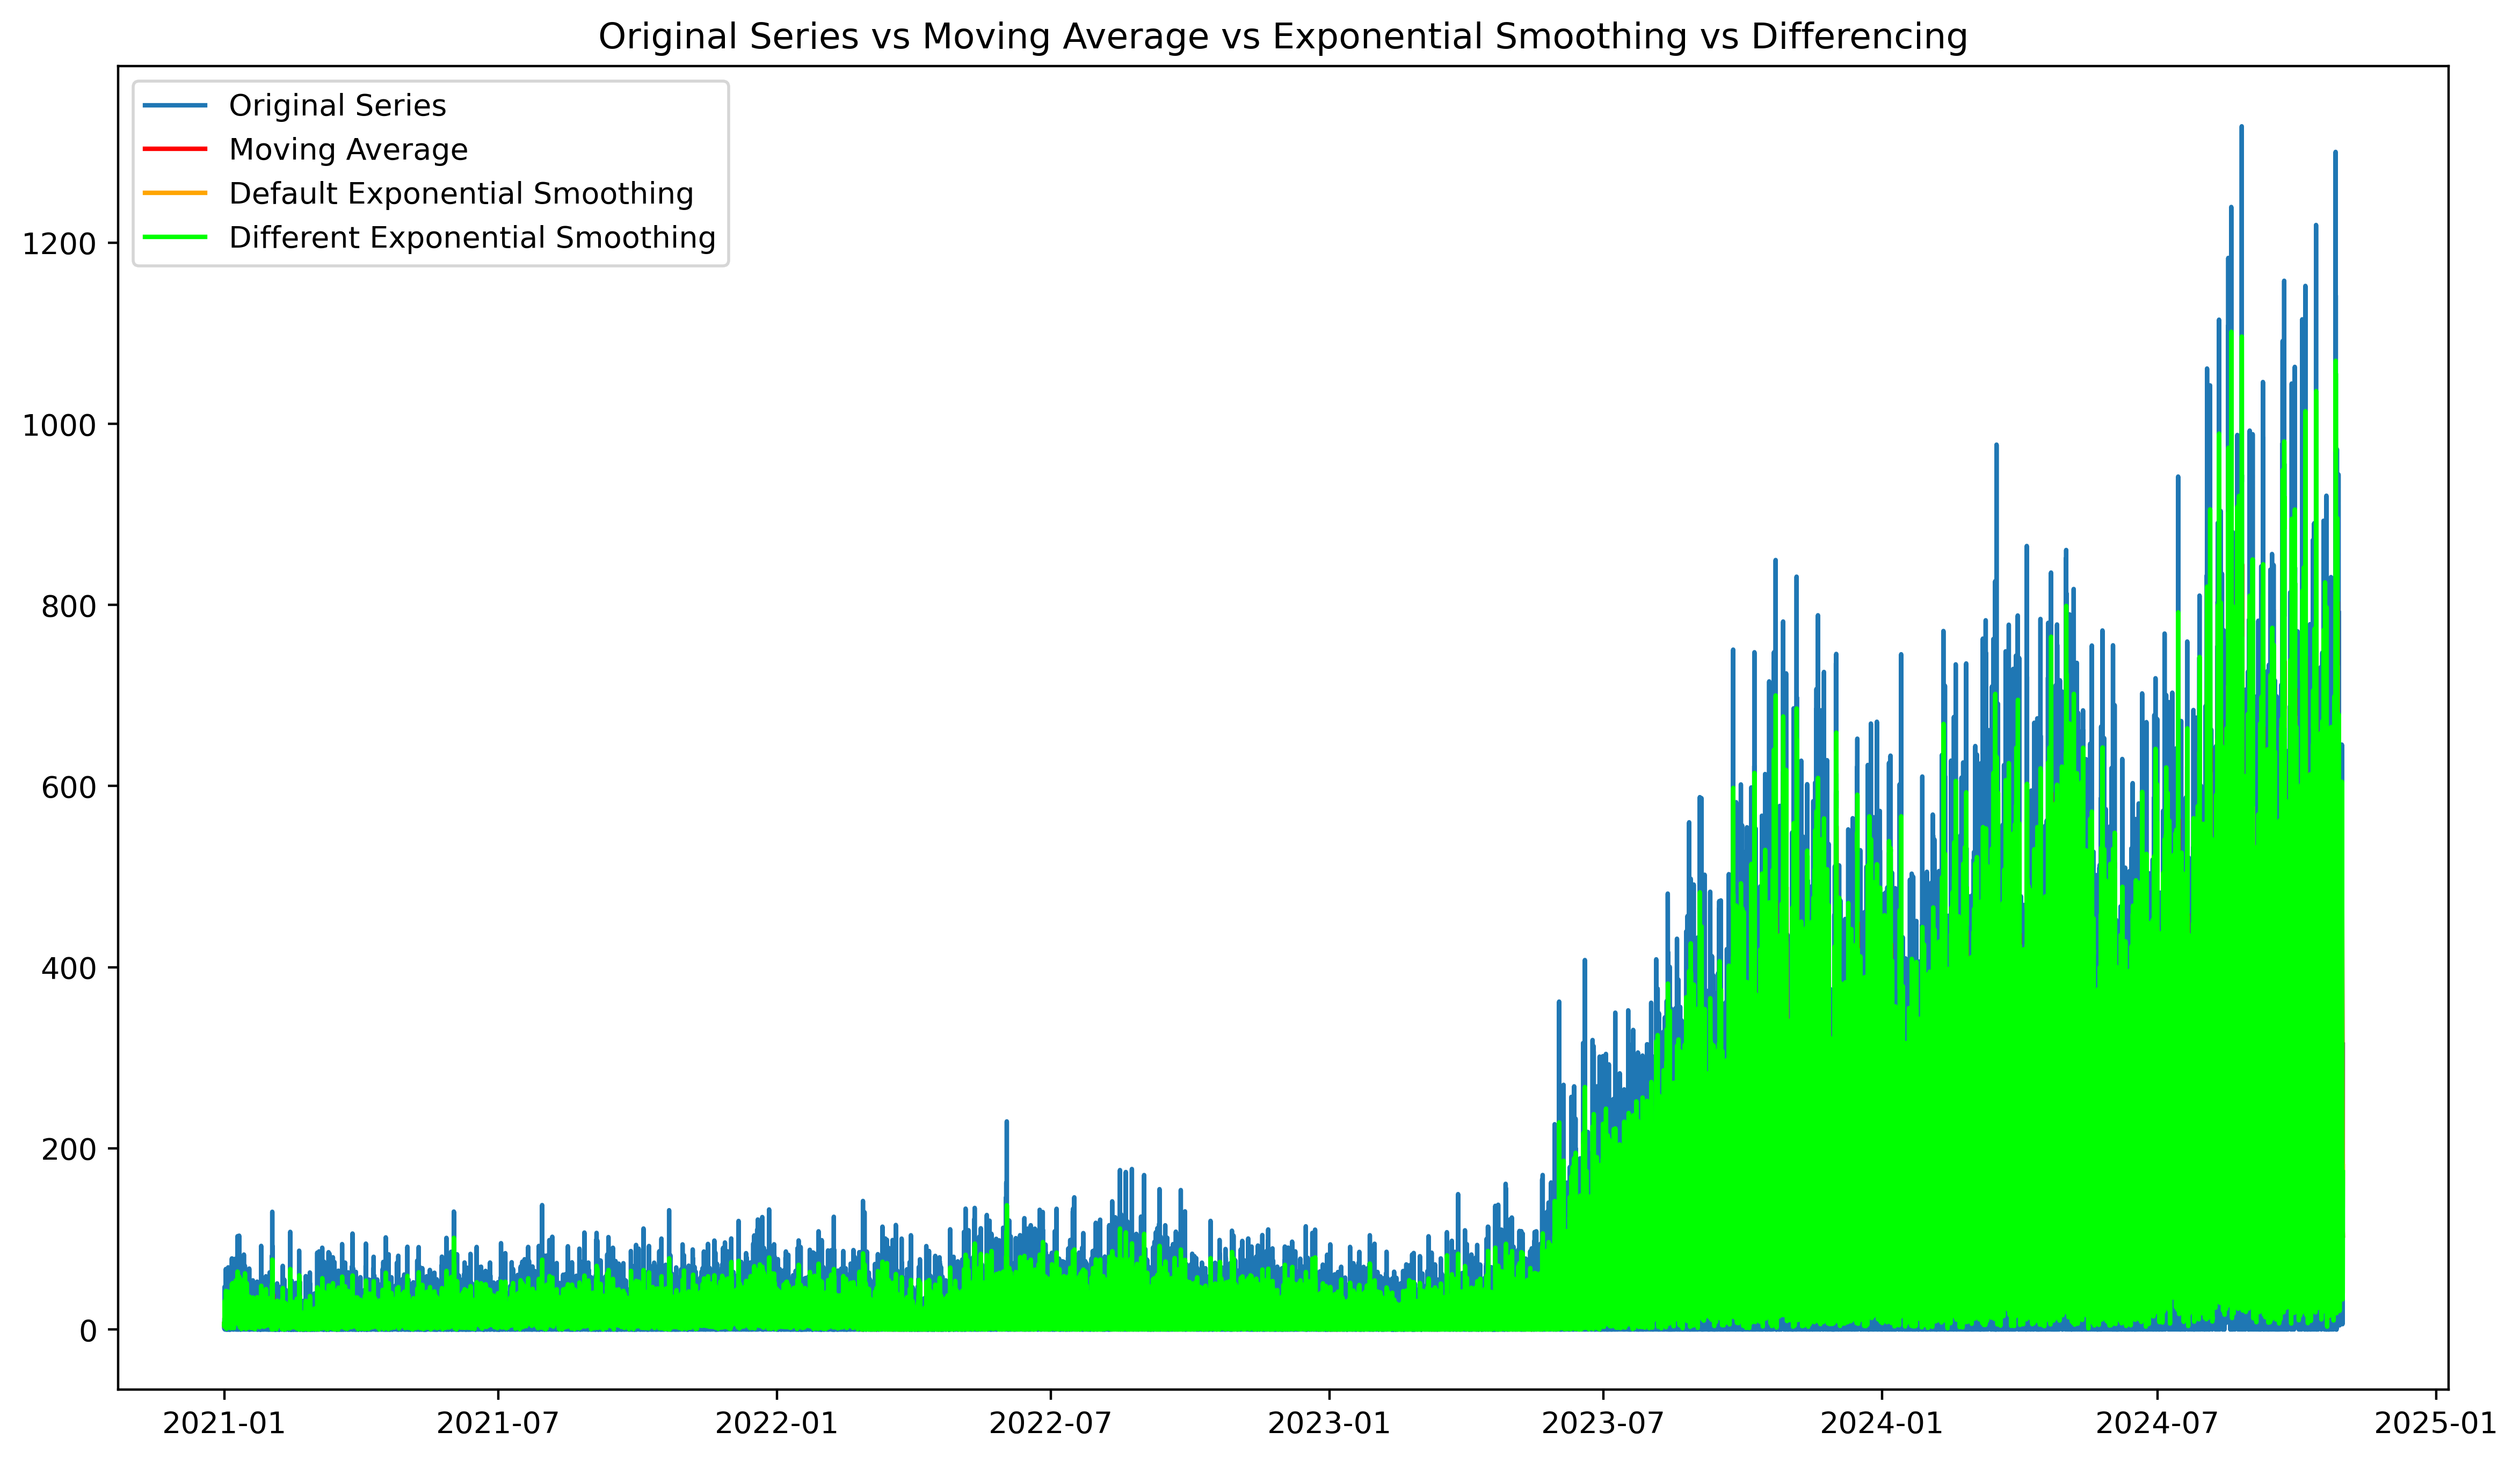

In [17]:
df['Moving_Average'] = df['kWh'].rolling(window=12).mean()
df['Exponential_Smoothing_alt'] = SimpleExpSmoothing(df['kWh']).fit(smoothing_level=0.5, optimized=True).fittedvalues
df['Exponential_Smoothing_default'] = df['kWh'].ewm(span=12).mean()
df['Differenced'] = df['kWh'].diff()

plt.plot(df.index, df['kWh'], label='Original Series')
plt.plot(df.index, df['Moving_Average'], label='Moving Average', color='red')
plt.plot(df.index, df['Exponential_Smoothing_default'], label='Default Exponential Smoothing', color='orange')
plt.plot(df.index, df['Exponential_Smoothing_alt'], label='Different Exponential Smoothing', color='lime')
# plt.plot(df['Date'], df['Differenced'], label='Differenced', color='lime')
plt.legend()
plt.title('Original Series vs Moving Average vs Exponential Smoothing vs Differencing')
plt.show()

Here is the comparasion of the original searies, to exponential smoothing from two different libaries, one that was used in the notebooks provided to us (Orange) and the different one I just found(lime). Moving average is the most smoothed, my new exp. smooth. is closes to the original series and the default exp. smotthing is somewhwere in betwheen

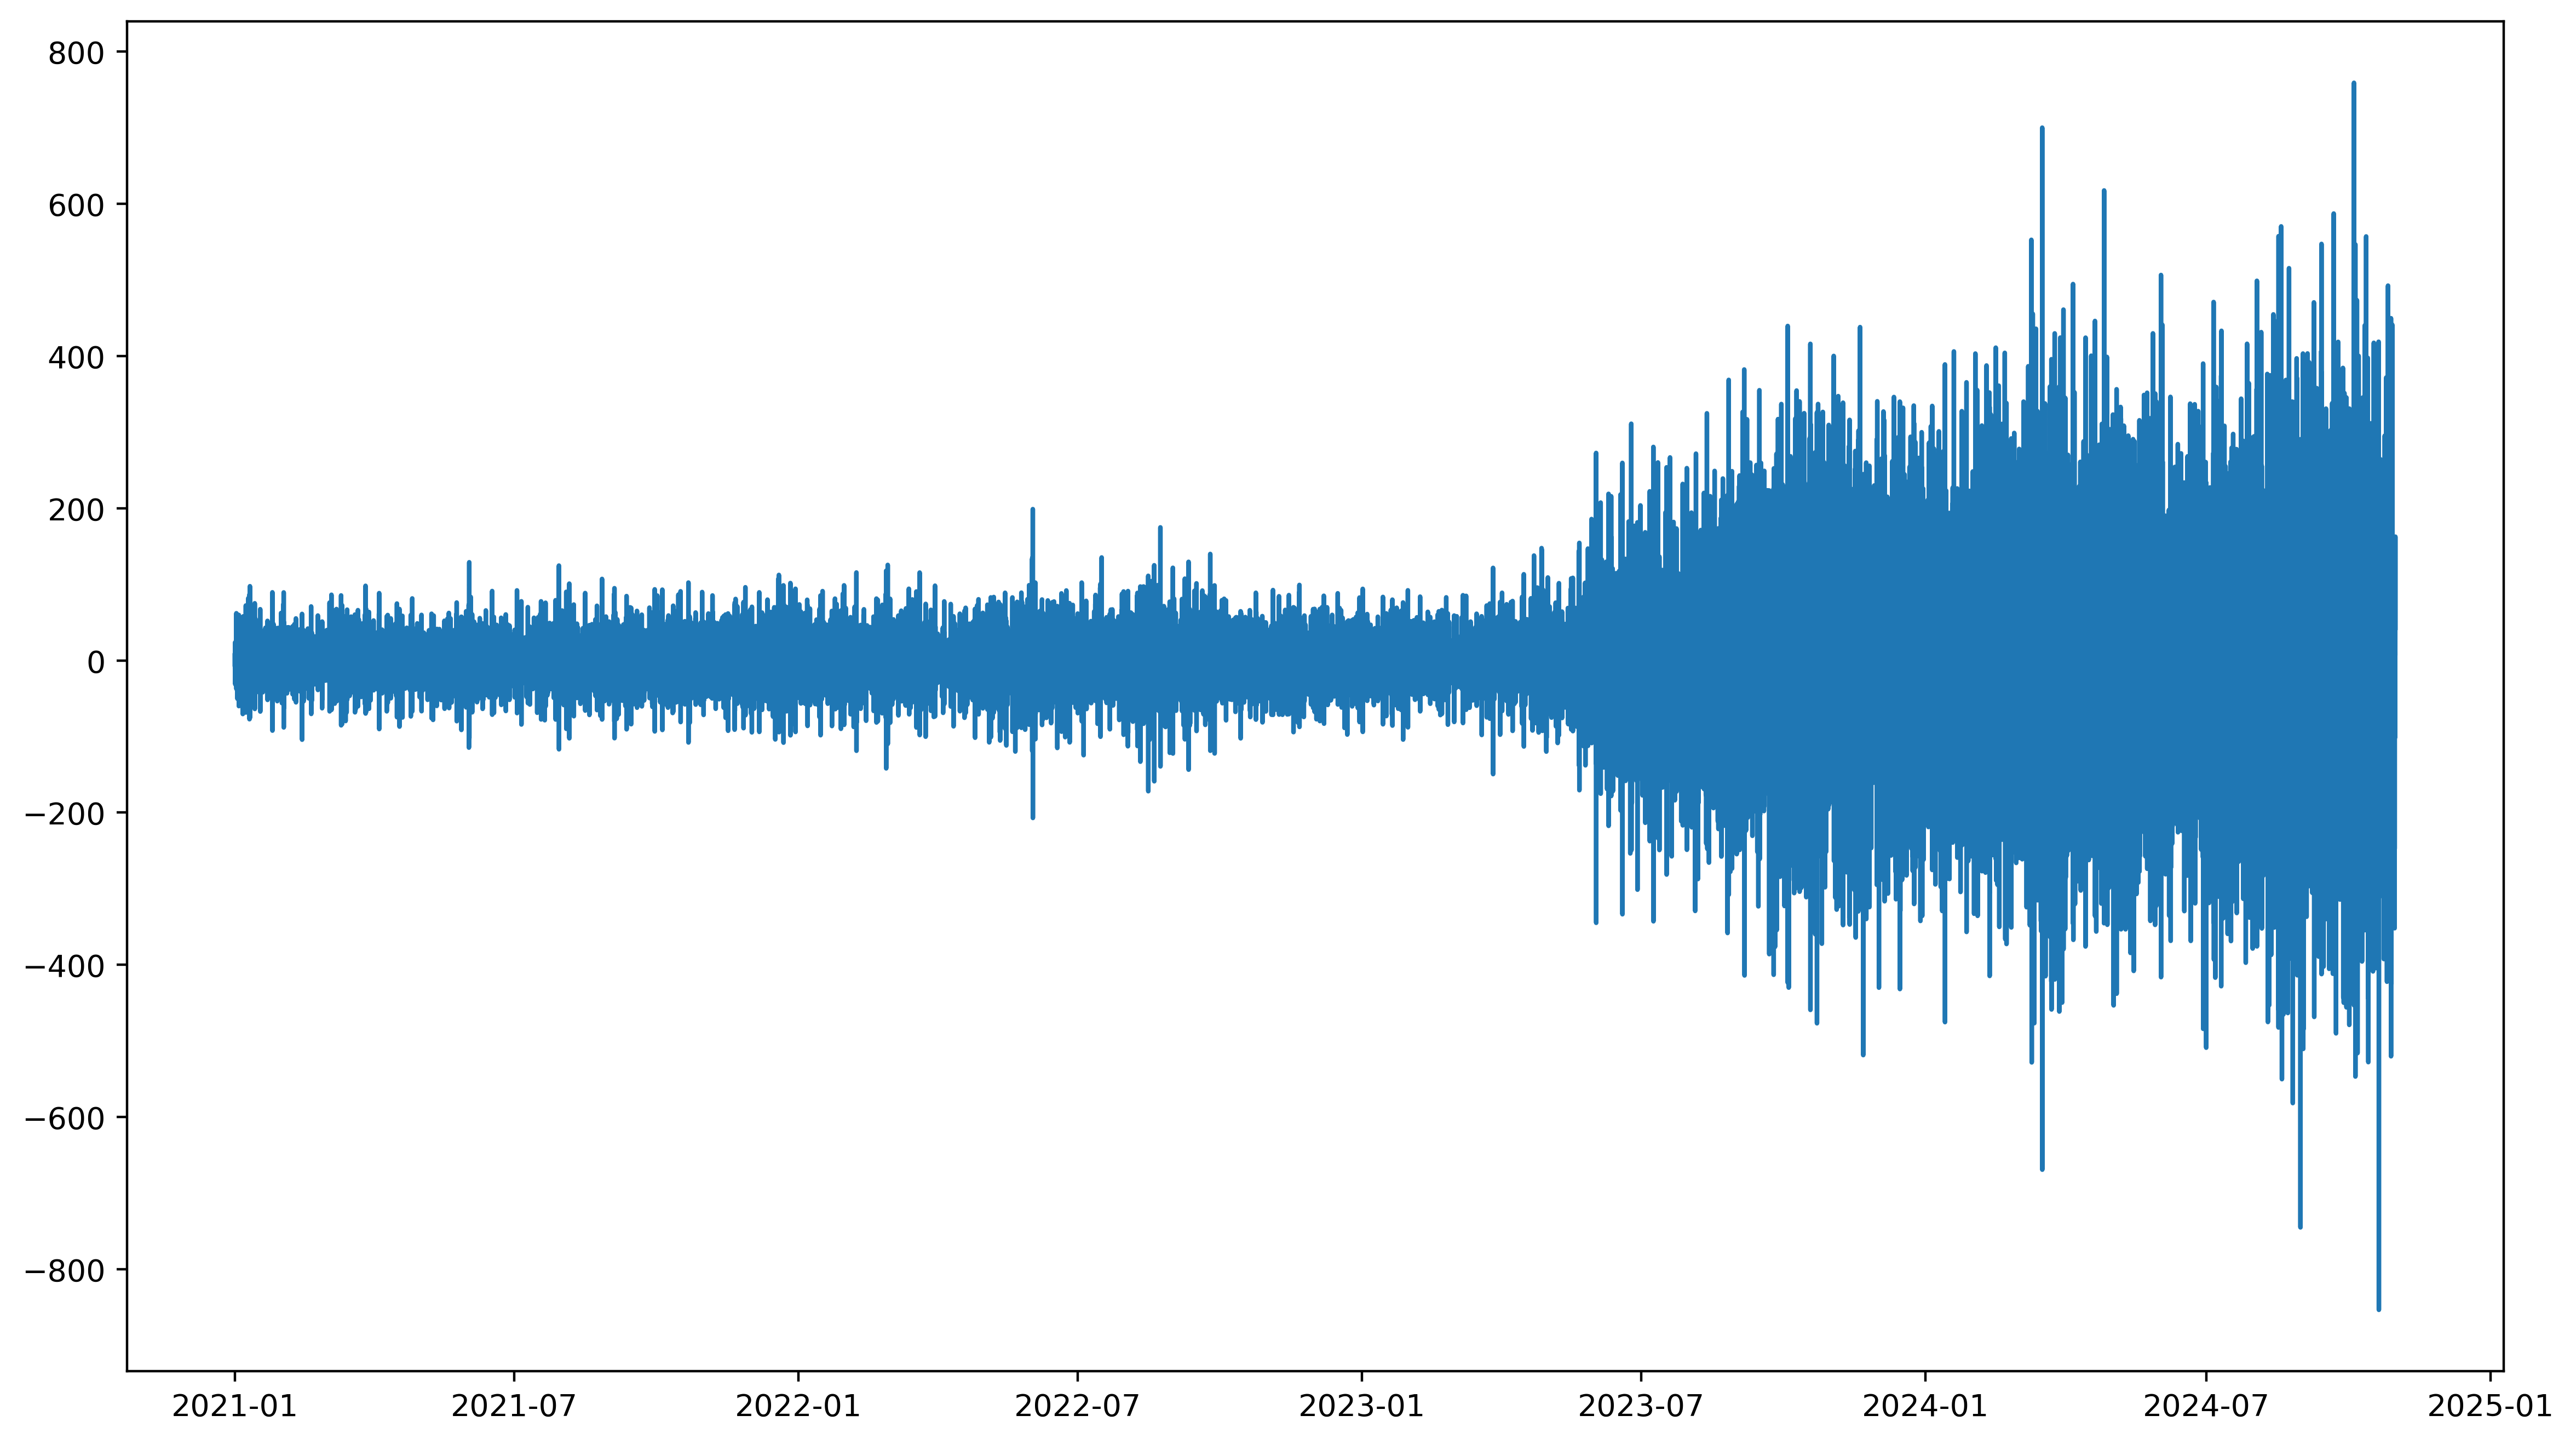

In [18]:
plt.plot(df.index, df['Differenced'], label='Differenced')
plt.show()

This is the data after differencing, seems stationary to me.

In [19]:
print('Differncing:')
print(ADF(df['Differenced'].dropna()).summary())

Differncing:
   Augmented Dickey-Fuller Results   
Test Statistic                -40.204
P-value                         0.000
Lags                               50
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


ADF proves that this data is indeed stationary.

# 3. Валідація двох альтернатив приведення до стаціонарного ряду: decomposition VS differencing; 

In [20]:
print('Differncing:')
print(ADF(df['Differenced'].dropna()).summary())

Differncing:
   Augmented Dickey-Fuller Results   
Test Statistic                -40.204
P-value                         0.000
Lags                               50
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [21]:
print('Decomposition (Additive):')
print(ADF(decomposition_additive.resid.dropna()).summary())

Decomposition (Additive):
   Augmented Dickey-Fuller Results   
Test Statistic                -49.352
P-value                         0.000
Lags                               52
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [22]:
print('Decomposition (Multiplicative):')
print(ADF(decomposition_multiplicative.resid.dropna(), lags=12).summary())

Decomposition (Multiplicative):
   Augmented Dickey-Fuller Results   
Test Statistic               -109.762
P-value                         0.000
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


According to ADF additive decomposition provides us with the highest degree of stationarity.

# 4. Тренування та валідація моделей Moving Average, Exponential Smoothing (single, double, triple), (для смузінгу провалідувати різні методи декомпозиції), підбір гіперпараметрів;

In [23]:
def k_folds(data, k, last):
    period = 12
    data = data.dropna(inplace = False)
    folds = []
    vals = []
    for number in range(k + 1, 1, -1):
        fold = data[:-period * number - last].asfreq('MS')
        val = data[(-period * number - last):(-period * (number - 1) - last)].asfreq('MS')
        folds.append(fold)
        vals.append(val)
    last_fold = data[:-last - period].asfreq('MS')
    test = data[-last - period:].asfreq('MS')
    return folds, vals, last_fold, test

folds, vals, last_fold, test = k_folds(df['kWh'], 4, 9)
series = df['kWh'].dropna()

### Moving average

In [24]:
# min_mape = float('inf')
# best_window = 0
# for i in range(2, 13):
#     moving_average = series.rolling(i, center=True).mean()
#     valid_mask = ~moving_average.isna()
#     current_mape = calc_mape(series[valid_mask], moving_average[valid_mask])
#     if current_mape <= min_mape:
#         min_mape = current_mape
#         best_window = i
# print(f"Min MAPE = {min_mape}")
# print(f"Window = {best_window}")

### Exp Smooth

In [25]:
# alpha_values = np.round(np.arange(0.1, 1, 0.1), decimals=1)
# min_mape = float('inf')
# best_alpha = alpha_values[0]
# for alpha in alpha_values:
#     mape = 0
#     for i in range(0, len(folds)):
#         single = SimpleExpSmoothing(folds[i]).fit(smoothing_level = alpha, optimized=False)
#         single_preds = single.forecast(len(vals[i]))
#         mape += calc_mape(vals[i], single_preds)
#     mape = mape / len(folds)
#     if mape <= min_mape:
#         min_mape = mape
#         best_alpha = alpha
# 
# print(f"Min MAPE = {min_mape}")
# print(f"Alpha = {best_alpha}")

### Double Exp Smooth

In [26]:
# alpha_values = np.round(np.arange(0.1, 1, 0.1), decimals=1)
# min_mape = float('inf')
# best_alpha = alpha_values[0]
# best_beta = alpha_values[0]
# for alpha in alpha_values:
#     for beta in alpha_values:
#         mape = 0
#         for i in range(0, len(folds)):
#             double = Holt(folds[i]).fit(smoothing_level=alpha,
#                 smoothing_trend=beta, optimized = False)
#             double_preds = double.forecast(len(vals[i]))
#             mape += calc_mape(vals[i], double_preds)
#         mape = mape / len(folds)
#         if mape <= min_mape:
#             min_mape = mape
#             best_alpha = alpha
#             best_beta = beta
# 
# print(f"Min MAPE = {min_mape}")
# print(f"Alpha = {best_alpha}")
# print(f"Beta = {best_beta}")

### Triple EXp Smooth Additive

In [27]:
# alpha_values = np.round(np.arange(0.1, 1, 0.1), decimals=1)
# min_mape = float('inf')
# best_alpha = alpha_values[0]
# best_beta = alpha_values[0]
# best_gama = alpha_values[0]
# for alpha in alpha_values:
#     for beta in alpha_values:
#         for gama in alpha_values:
#             mape = 0
#             for i in range(0, len(folds)):
#                 triple = ExponentialSmoothing(folds[i],
#                     trend="additive",
#                     seasonal="additive",
#                     seasonal_periods=12).fit(smoothing_level=alpha,
#                     smoothing_trend=beta, smoothing_seasonal=gama, optimized = False)
#                 triple_preds = triple.forecast(len(vals[i]))
#                 mape += calc_mape(vals[i], triple_preds)
#             mape = mape / len(folds)
#             if mape <= min_mape:
#                 min_mape = mape
#                 best_alpha = alpha
#                 best_beta = beta
#                 best_gama = gama
# 
# print(f"Min MAPE = {min_mape}")
# print(f"Alpha = {best_alpha}")
# print(f"Beta = {best_beta}")
# print(f"Gama = {best_gama}")

### Triple EXp Smooth Multiplicative

In [28]:
# alpha_values = np.round(np.arange(0.1, 1, 0.1), decimals=1)
# min_mape = float('inf')
# best_alpha = alpha_values[0]
# best_beta = alpha_values[0]
# best_gama = alpha_values[0]
# for alpha in alpha_values:
#     for beta in alpha_values:
#         for gama in alpha_values:
#             mape = 0
#             for i in range(0, len(folds)):
#                 triple = ExponentialSmoothing(folds[i],
#                     trend="multiplicative",
#                     seasonal="multiplicative",
#                     seasonal_periods=12).fit(smoothing_level=alpha,
#                     smoothing_trend=beta, smoothing_seasonal=gama, optimized = False)
#                 triple_preds = triple.forecast(len(vals[i]))
#                 mape += calc_mape(vals[i], triple_preds)
#             mape = mape / len(folds)
#             if mape <= min_mape:
#                 min_mape = mape
#                 best_alpha = alpha
#                 best_beta = beta
#                 best_gama = gama
# 
# print(f"Min MAPE = {min_mape}")
# print(f"Alpha = {best_alpha}")
# print(f"Beta = {best_beta}")
# print(f"Gama = {best_gama}")

Since Triple Exp Smooth model is clearly the best one with the lowest MAPE I will only test it.

### Additive test

In [29]:
# triple = ExponentialSmoothing(last_fold,
#     trend="additive",
#     seasonal="additive",
#     seasonal_periods=12).fit(smoothing_level=0.1,
#     smoothing_trend=0.1, smoothing_seasonal=0.3, optimized = False)
# triple_preds = triple.forecast(len(test), index=test.index)
# print(f"MAPE = {calc_mape(test, triple_preds)}")

### Multiplicative test

In [30]:
# triple = ExponentialSmoothing(last_fold,
#     trend="multiplicative",
#     seasonal="multiplicative",
#     seasonal_periods=12).fit(smoothing_level=0.1,
#     smoothing_trend=0.1, smoothing_seasonal=0.2, optimized = False)
# triple_preds = triple.forecast(len(test))
# print(f"MAPE = {calc_mape(test, triple_preds)}")

It's weird that here multiplicative model seems to better than additive, while previously when comparing them head to head it was worse. Why this is I am not sure.

In [31]:
# plt.plot(df['kWh'])
# plt.plot(triple_preds)
# plt.show()

As we can see both models perform significantly worse on the test data with the multiplicative one faring a bit better.

# 5. Тренування та валідація MA, AR, ARMA, ARIMA моделей, використовуючи additive, multiplicative decomposition та differencing, підбір гіперпараметрів.

I find ACF and PACF quirky und unhelpful and prefer brute force as it provides us with an oportunity to test all possible models and find the best one based on actual data and not on some feeling. But I do understand the drawbacks of such an approach -- it can lead to overfitting and is VERY compuatationally intensive.

## MA

### Additive

In [32]:
# folds, vals, last_fold, test = k_folds(decomposition_additive.resid, 4, 3)
# min_mape = float('inf')
# for i in range(1,13):
#     mape = 0
#     for j in range(0, len(folds)):
#         model = ARIMA(endog = folds[j], order = (0,0,i), dates = folds[j].index).fit()
#         predictions = model.predict(start = vals[j].index[0], end = vals[j].index[-1])
#         mape = + calc_mape(vals[j], predictions)
#         predictions += decomposition_additive.trend + decomposition_additive.seasonal
#     mape = mape / len(folds)
#     if mape <= min_mape:
#         min_mape = mape
#         best_i = i
# 
# print(f'Min Mape = {min_mape}')
# print(f"MA({best_i})")

In [34]:
model = ARIMA(endog = last_fold, order = (0,0,5), dates = last_fold.index).fit()
predictions = model.predict(start = test.index[0], end = test.index[-1])
mape = calc_mape(test, predictions)
predictions += decomposition_additive.trend + decomposition_additive.seasonal

print(f'MAPE = {mape}')
plt.plot(decomposition_additive.resid + decomposition_additive.trend + decomposition_additive.seasonal)
plt.plot(predictions)
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

### Multiplicative

In [ ]:
# folds, vals, last_fold, test = k_folds(decomposition_multiplicative.resid, 4, 3)
# min_mape = float('inf')
# for i in range(1,13):
#     mape = 0
#     for j in range(0, len(folds)):
#         model = ARIMA(endog = folds[j], order = (0,0,i), dates = folds[j].index).fit()
#         predictions = model.predict(start = vals[j].index[0], end = vals[j].index[-1])
#         predictions *= decomposition_multiplicative.trend * decomposition_multiplicative.seasonal
#         vals[j] *=  decomposition_multiplicative.trend * decomposition_multiplicative.seasonal
#         mape = + calc_mape(vals[j], predictions)
#     mape = mape / len(folds)
#     if mape <= min_mape:
#         min_mape = mape
#         best_i = i
# 
# print(f'Min Mape = {min_mape}')
# print(f"MA({best_i})")

In [ ]:
model = ARIMA(endog = last_fold, order = (0,0,best_i), dates = last_fold.index).fit()
predictions = model.predict(start = test.index[0], end = test.index[-1])
predictions *= decomposition_multiplicative.trend * decomposition_multiplicative.seasonal
test *= decomposition_multiplicative.trend * decomposition_multiplicative.seasonal
mape = calc_mape(test, predictions)

print(f'MAPE = {mape}')
plt.plot(decomposition_multiplicative.resid * decomposition_multiplicative.trend * decomposition_multiplicative.seasonal)
plt.plot(predictions)
plt.show()

### Differenced

In [ ]:
# folds, vals, last_fold, test = k_folds(df['Differenced'], 4, 3)
# min_mape = float('inf')
# for i in range(1,13):
#     mape = 0
#     for j in range(0, len(folds)):
#         model = ARIMA(endog = folds[j], order = (0,0,i), dates = folds[j].index).fit()
#         predictions = model.predict(start = vals[j].index[0], end = vals[j].index[-1])
#         mape = + calc_mape(vals[j], predictions)
#     mape = mape / len(folds)
#     if mape <= min_mape:
#         min_mape = mape
#         best_i = i
# 
# print(f'Min Mape = {min_mape}')
# print(f"MA({best_i})")

In [ ]:
model = ARIMA(endog = last_fold, order = (0,0,best_i), dates = last_fold.index).fit()
predictions = model.predict(start = test.index[0], end = test.index[-1])
mape = calc_mape(test, predictions)

print(f'MAPE = {mape}')
plt.plot(df['Differenced'])
plt.plot(predictions)
plt.show()

## AR

### Additive

In [ ]:
# folds, vals, last_fold, test = k_folds(decomposition_additive.resid, 4, 3)
# min_mape = float('inf')
# for i in range(1,13):
#     mape = 0
#     for j in range(0, len(folds)):
#         model = ARIMA(endog = folds[j], order = (i,0,0), dates = folds[j].index).fit()
#         predictions = model.predict(start = vals[j].index[0], end = vals[j].index[-1])
#         mape = + calc_mape(vals[j], predictions)
#         predictions += decomposition_additive.trend + decomposition_additive.seasonal
#     mape = mape / len(folds)
#     if mape <= min_mape:
#         min_mape = mape
#         best_i = i
# 
# print(f'Min Mape = {min_mape}')
# print(f"AR({best_i})")

In [ ]:
model = ARIMA(endog = last_fold, order = (best_i,0,0), dates = last_fold.index).fit()
predictions = model.predict(start = test.index[0], end = test.index[-1])
mape = calc_mape(test, predictions)
predictions += decomposition_additive.trend + decomposition_additive.seasonal

print(f'MAPE = {mape}')
plt.plot(decomposition_additive.resid + decomposition_additive.trend + decomposition_additive.seasonal)
plt.plot(predictions)
plt.show()

### Multiplicative

In [ ]:
# folds, vals, last_fold, test = k_folds(decomposition_multiplicative.resid, 4, 3)
# min_mape = float('inf')
# for i in range(1,13):
#     mape = 0
#     for j in range(0, len(folds)):
#         model = ARIMA(endog = folds[j], order = (i,0,0), dates = folds[j].index).fit()
#         predictions = model.predict(start = vals[j].index[0], end = vals[j].index[-1])
#         predictions *= decomposition_multiplicative.trend * decomposition_multiplicative.seasonal
#         vals[j] *=  decomposition_multiplicative.trend * decomposition_multiplicative.seasonal
#         mape = + calc_mape(vals[j], predictions)
#     mape = mape / len(folds)
#     if mape <= min_mape:
#         min_mape = mape
#         best_i = i
# 
# print(f'Min Mape = {min_mape}')
# print(f"AR({best_i})")

In [ ]:
model = ARIMA(endog = last_fold, order = (best_i,0,0), dates = last_fold.index).fit()
predictions = model.predict(start = test.index[0], end = test.index[-1])
predictions *= decomposition_multiplicative.trend * decomposition_multiplicative.seasonal
test *= decomposition_multiplicative.trend * decomposition_multiplicative.seasonal
mape = calc_mape(test, predictions)

print(f'MAPE = {mape}')
plt.plot(decomposition_multiplicative.resid * decomposition_multiplicative.trend * decomposition_multiplicative.seasonal)
plt.plot(predictions)
plt.show()

### Differenced

In [ ]:
# folds, vals, last_fold, test = k_folds(df['Differenced'], 4, 3)
# min_mape = float('inf')
# for i in range(1,13):
#     mape = 0
#     for j in range(0, len(folds)):
#         model = ARIMA(endog = folds[j], order = (i,0,0), dates = folds[j].index).fit()
#         predictions = model.predict(start = vals[j].index[0], end = vals[j].index[-1])
#         mape = + calc_mape(vals[j], predictions)
#     mape = mape / len(folds)
#     if mape <= min_mape:
#         min_mape = mape
#         best_i = i
# 
# print(f'Min Mape = {min_mape}')
# print(f"AR({best_i})")

In [ ]:
model = ARIMA(endog = last_fold, order = (best_i,0,0), dates = last_fold.index).fit()
predictions = model.predict(start = test.index[0], end = test.index[-1])
mape = calc_mape(test, predictions)

print(f'MAPE = {mape}')
plt.plot(df['Differenced'])
plt.plot(predictions)
plt.show()

## ARMA

From now on I stopped calculating the best possible model through brute force as it got too cumputationaly intensive. Obviously were this something really imporatnt I'd continue but it's just a homework task. Instead I based my choices of the first and third parameters on PACF and ACF respectively. For the second parameter, representing differencing(only in ARIMA) I just played around to see what's best.

### Additive

In [ ]:
folds, vals, last_fold, test = k_folds(decomposition_additive.resid, 4, 3)
model = ARIMA(endog = last_fold, order = (1,0,1), dates = last_fold.index).fit()
predictions = model.predict(start = test.index[0], end = test.index[-1])
mape = calc_mape(test, predictions)
predictions += decomposition_additive.trend + decomposition_additive.seasonal

print(f'MAPE = {mape}')
plt.plot(decomposition_additive.resid + decomposition_additive.trend + decomposition_additive.seasonal)
plt.plot(predictions)
plt.show()

### Multiplicative

In [ ]:
folds, vals, last_fold, test = k_folds(decomposition_multiplicative.resid, 4, 3)
model = ARIMA(endog = last_fold, order = (1,0,1), dates = last_fold.index).fit()
predictions = model.predict(start = test.index[0], end = test.index[-1])
predictions *= decomposition_multiplicative.trend * decomposition_multiplicative.seasonal
test *= decomposition_multiplicative.trend * decomposition_multiplicative.seasonal
mape = calc_mape(test, predictions)
print(f'MAPE = {mape}')
plt.plot(decomposition_additive.resid + decomposition_additive.trend + decomposition_additive.seasonal)
plt.plot(predictions)
plt.show()

### Differenced

In [ ]:
folds, vals, last_fold, test = k_folds(df['Differenced'], 4, 3)
model = ARIMA(endog = last_fold, order = (1,0,1), dates = last_fold.index).fit()
predictions = model.predict(start = test.index[0], end = test.index[-1])
mape = calc_mape(test, predictions)

print(f'MAPE = {mape}')
plt.plot(df['Differenced'])
plt.plot(predictions)
plt.show()

## ARIMA

### Additive

In [ ]:
folds, vals, last_fold, test = k_folds(decomposition_additive.resid, 4, 3)
model = ARIMA(endog = last_fold, order = (1,1,8), dates = last_fold.index).fit()
predictions = model.predict(start = test.index[0], end = test.index[-1])
mape = calc_mape(test, predictions)
predictions += decomposition_additive.trend + decomposition_additive.seasonal

print(f'MAPE = {mape}')
plt.plot(decomposition_additive.resid + decomposition_additive.trend + decomposition_additive.seasonal)
plt.plot(predictions)
plt.show()

### Multiplicative

In [ ]:
folds, vals, last_fold, test = k_folds(decomposition_multiplicative.resid, 4, 3)
model = ARIMA(endog = last_fold, order = (1,3,8), dates = last_fold.index).fit()
predictions = model.predict(start = test.index[0], end = test.index[-1])
predictions *= decomposition_multiplicative.trend * decomposition_multiplicative.seasonal
test *= decomposition_multiplicative.trend * decomposition_multiplicative.seasonal
mape = calc_mape(test, predictions)
print(f'MAPE = {mape}')
plt.plot(decomposition_additive.resid + decomposition_additive.trend + decomposition_additive.seasonal)
plt.plot(predictions)
plt.show()

### Differenced

In [ ]:
folds, vals, last_fold, test = k_folds(df['Differenced'], 4, 3)
model = ARIMA(endog = last_fold, order = (1,2,8), dates = last_fold.index).fit()
predictions = model.predict(start = test.index[0], end = test.index[-1])
mape = calc_mape(test, predictions)

print(f'MAPE = {mape}')
plt.plot(df['Differenced'])
plt.plot(predictions)
plt.show()

Overall my best models are multiplicative, despite additive seeming better at the start. The best model is multiplicative ARIMA(1,3,8) with ARMA(1,1), MA(1) and AR(8) following close behind.